# Notebook for analysing all VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)


In [1]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRAnalysis/')
from flyVR_oneTrialBasicAnalysis import singleVRTrialAnalysis

path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import makeNestedPlotDirectory, myAxisTheme
from objectInteractionPlots import residencyWithHistograms_splitOnWalking, residencyWithHistograms,\
        radDistAngleCombiPlot, plotResidencyInMiniarena, make4ValuePolCoordPlot
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import relationToObject, cartesian2polar, polarCurvature
from plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df, plotVeloHeadingDistribution2_flyVR_df,\
                               oneDimResidency_df, oneDimResidencyWithVar_df, turnRatePerDistance
plotPolarTrace

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['WTBxpBDPGal4m01', 'WTBxpBDPGal4m02', 'WTBxpBDPGal4m03', 'WTBxpBDPGal4m04', 'WTBxpBDPGal4m05', 'WTBxpBDPGal4m06', 'WTBxpBDPGal4m07', 'WTBxpBDPGal4m08', 'WTBxpBDPGal4m09', 'WTBxpBDPGal4m10', 'WTBxpBDPGal4m11', 'WTBxpBDPGal4m12', 'WTBxpBDPGal4m13', 'WTBxpBDPGal4m14', 'WTBxpBDPGal4m15', 'WTBxpBDPGal4m16', 'WTBxpBDPGal4m17', 'WTBxpBDPGal4m18', 'WTBxpBDPGal4m19', 'WTBxpBDPGal4m20', 'WTBxpBDPGal4m21']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [6]:
expDirs = expDirs[:20]
#my_indices = [0,4,7,10,11,13,17,19] #[1,2,3,4,5,9,10,14,15,17,18]
#expDirs = [expDirs[i] for i in my_indices]
#expDirs

### Compose mutli-fly data into dataframe

In [23]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [24]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [25]:
keylist = ['curvature','gamma','gammaFull','headingAngle','objectDistance','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena']

keylistLong = ['flyID','trial','trialtype','moving','walking'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [26]:
nTrialsVI = 0
nTrialsIN = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = fileToAnalyse.split('_')[0]#[-4]
        genotype = fileToAnalyse.split('_')[0][:-3]#[-5]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVRTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'Invisible' in fileToAnalyse or 'invisible' in fileToAnalyse:
            trialtype = 'invisible'
            nTrialsIN += 1
        else:
            trialtype = 'visible'
            nTrialsVI += 1
        
        # test if moving
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH
        
        # test if in walking bout
        vTrans_filt = np.copy(vTrans)
        vTrans_filt[vTrans_filt>30.0] = 0
        vTrans_filt = gaussian_filter(vTrans_filt, sigma=3)

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver093_highContrast/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m01/

 Analysing the following log files:

['WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151106201158.txt', 'WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151106202222.txt', 'WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151106210311.txt', 'WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_out_151106211619.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver093_highContrast/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m02/

 Analysing the following log files:

['WTBxpBDPGal4m02_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_15110

In [27]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

flyID trial  trialtype  moving  walking  curvature  gamma  \
0      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
1      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
2      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
3      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
4      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
5      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
6      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
7      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
8      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
9      WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
10     WTBxpBDPGal4m01     1    visible       0      NaN        NaN    NaN   
11     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
12     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
13     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
14     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
15     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
16     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
17     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
18     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
19     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
20     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
21     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
22     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
23     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
24     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
25     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
26     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
27     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
28     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
29     WTBxpBDPGal4m01     1    visible       1      NaN        NaN    NaN   
...                ...   ...        ...     ...      ...        ...    ...   
11970  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11971  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11972  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11973  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11974  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11975  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11976  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11977  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11978  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11979  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11980  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11981  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11982  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11983  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11984  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11985  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11986  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11987  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11988  WTBxpBDPGal4m20     4  invisible       0      NaN        NaN    NaN   
11989  WTBxpBDPGal4m20     4  invisible

In [28]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_objD = keylistLong.index('objectDistance')

genotypeSex = fileToAnalyse.split('_')[0][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

arenaRad = 60

##Experimental conditions

In [13]:
visibilityState = ['visible','visible','visible','invisible']
groundPlane = ['texture','texture','texture','texture']
trialName = ['obj + tex','obj + tex','obj + tex','tex']
arenaRad = 60

## Summary plot of walking traces

/Users/hannah/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


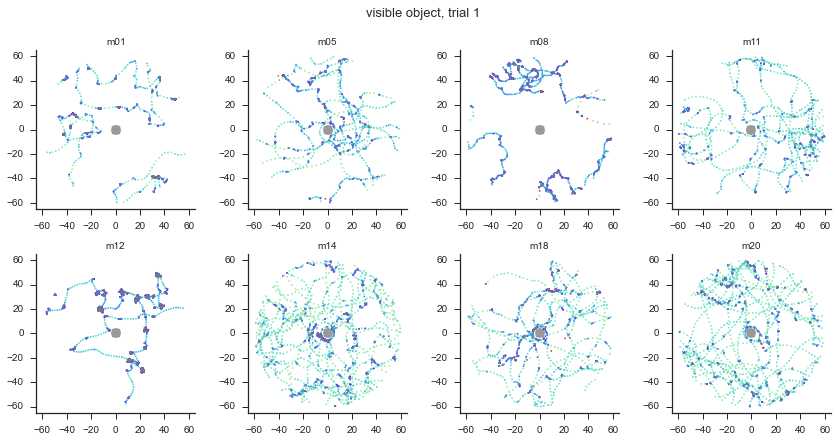

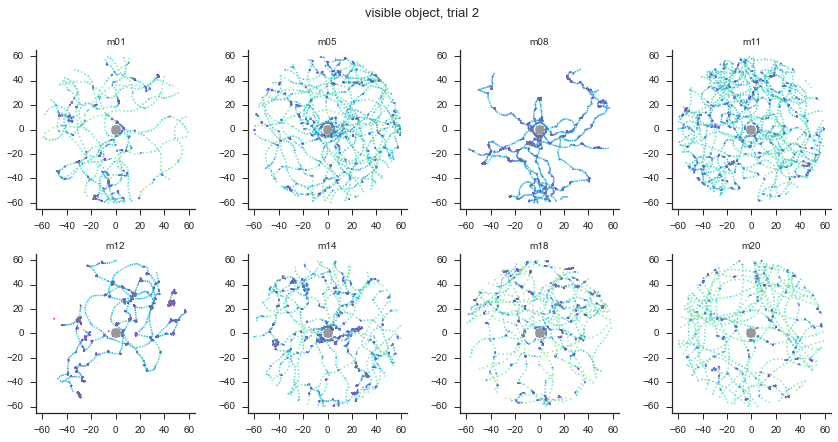

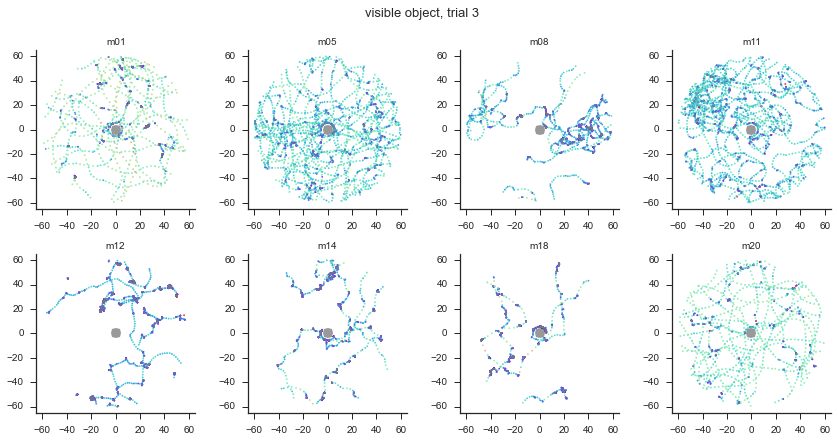

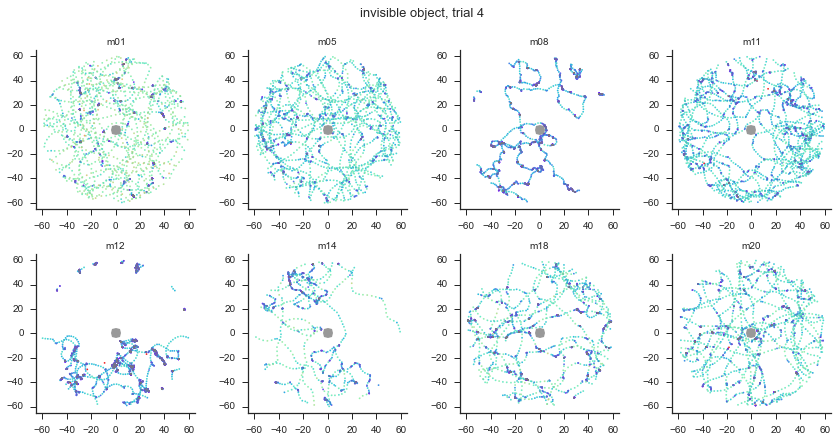

In [137]:
for ttind,trialtype in enumerate(visibilityState):
    multiflyTracePlot = plt.figure(figsize=(12,14))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object, trial '+str(ttind+1) ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(5,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (trial==' + str(ttind+1) + ') & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
        
        selectPts = range(0,len(perFlyX),4)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        multiflyTracePlot_sbplt.plot(0,0,'o',markersize=10, color='black', alpha=0.4)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-arenaRad-5, arenaRad + 5)
        multiflyTracePlot_sbplt.set_ylim(-arenaRad-5, arenaRad + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir + 'tracePlotMA/'  + genotypeSex + '_' + trialtype
                              + '_traceVeloColored_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

In [ ]:
for fly in range(numFlies):
    querystring = '(flyID == "'+ flyIDs[fly] +  '")'
    perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')

    percentMoving = (100.0*sum(perFlyMoving))/max(1,len(perFlyMoving))

    if percentMoving >= 30.0:
        #print(percentMoving)
        print(flyIDs[fly]) 

In [190]:
trial = 0
for fly in range(numFlies):
            
    querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
    perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')

    percentMoving = (100.0*sum(perFlyMoving))/max(1,len(perFlyMoving))

    if percentMoving >= 25.0:
        print(flyIDs[fly] + ' trial '+ str(trial+1))        

m02 trial 1
m05 trial 1
m07 trial 1
m08 trial 1
m11 trial 1
m12 trial 1
m14 trial 1
m15 trial 1
m18 trial 1
m19 trial 1
m20 trial 1


## Velocity and relative heading distribution

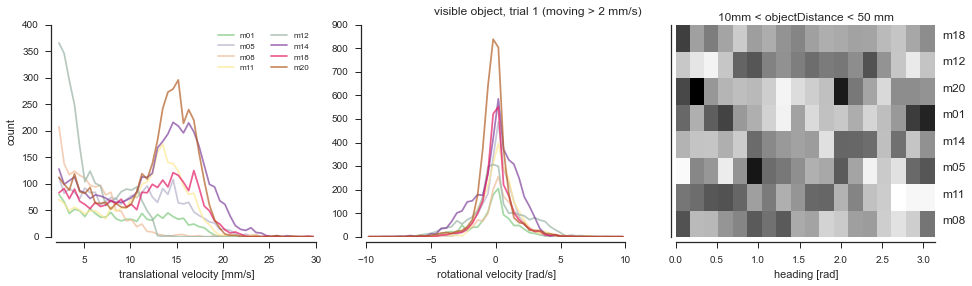

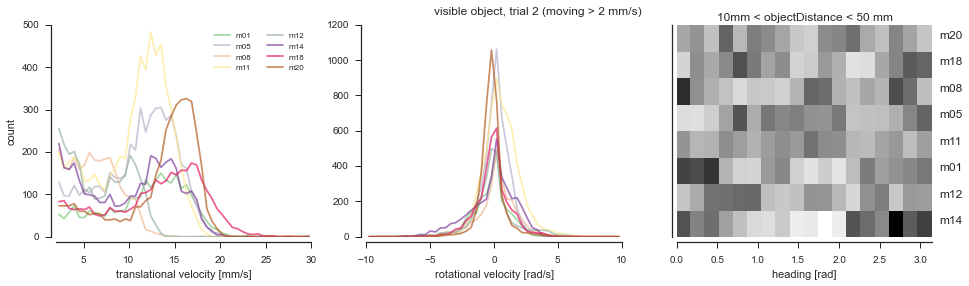

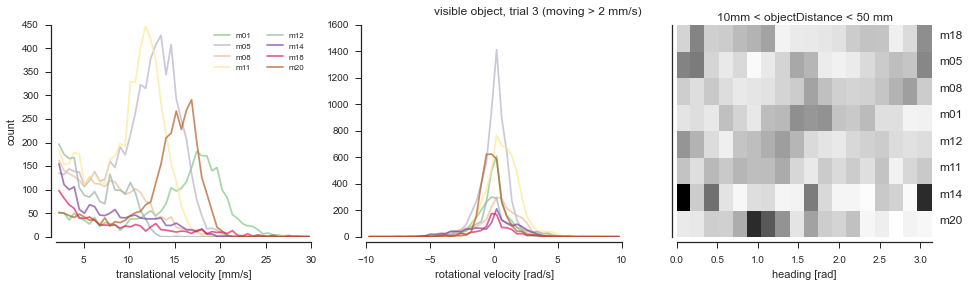

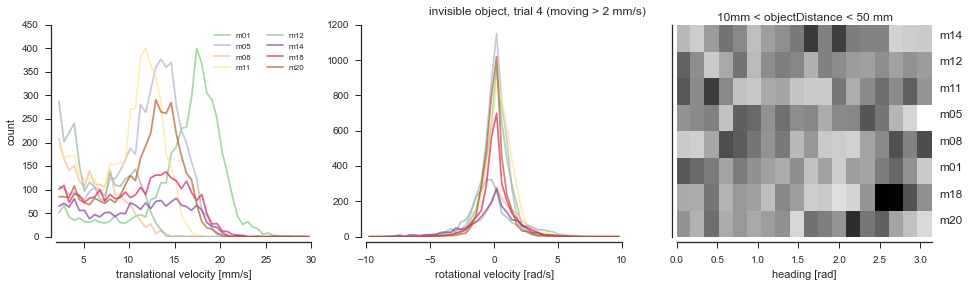

In [139]:
for ttind,trialtype in enumerate(visibilityState):
    
    veloDistFig = plotVeloHeadingDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong,
                                                       vTransTH, 10, 50)
    veloDistFig.tight_layout()
    
    veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotypeSex + '_' + trialtype
                        + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

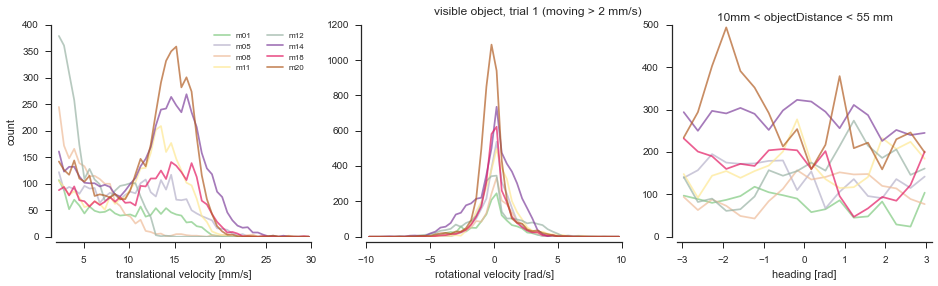

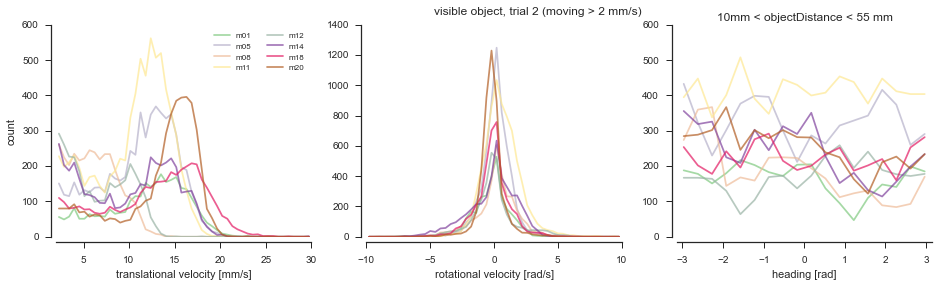

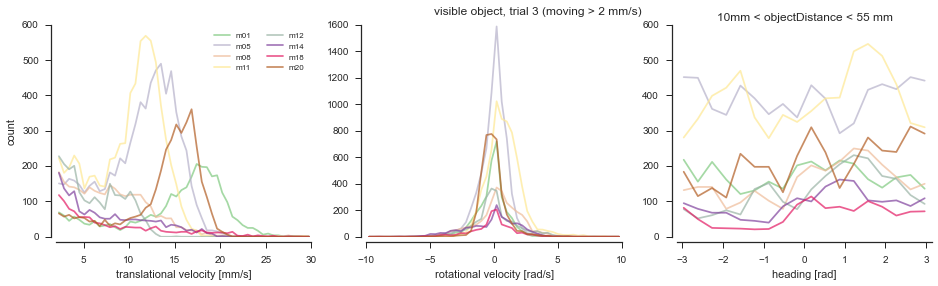

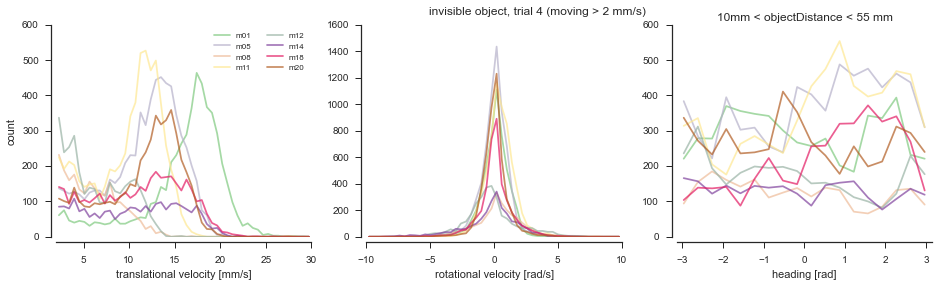

In [140]:
for ttind,trialtype in enumerate(visibilityState):
    
    veloDistFig = plotVeloHeadingDistribution2_flyVR_df(FOAllFlies_df,'all',trialtype, str(ttind+1), flyIDs, keylistLong,
                                                        vTransTH,10,55)
    veloDistFig.tight_layout()
    
    veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotypeSex + '_' + trialtype
                        + '_veloDistributions2_12Hz_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

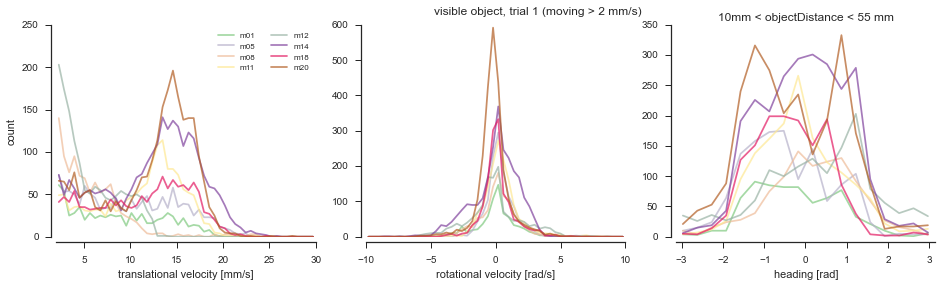

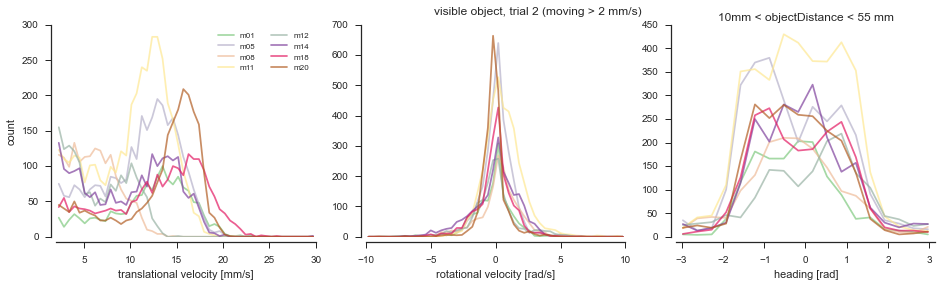

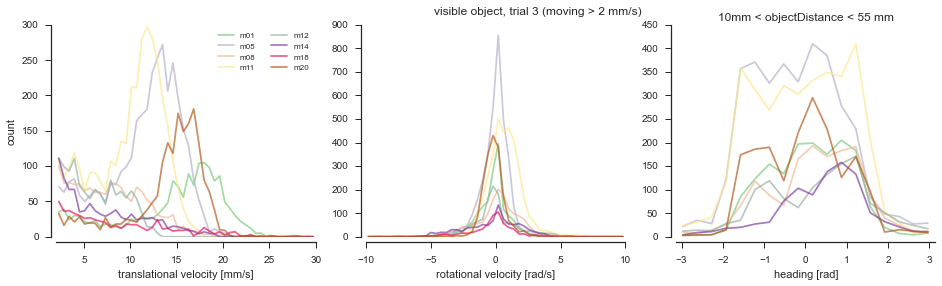

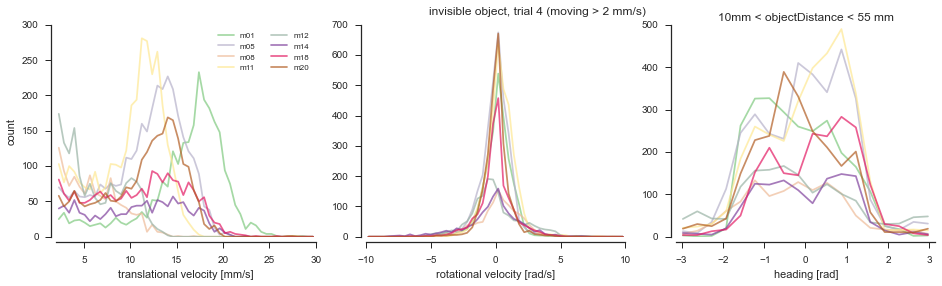

In [141]:
for ttind,trialtype in enumerate(visibilityState):
    veloDistFig = plotVeloHeadingDistribution2_flyVR_df(FOAllFlies_df, 'approach',trialtype, str(ttind+1), flyIDs, keylistLong,
                                                        vTransTH,10,55)
    veloDistFig.tight_layout()

    veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotypeSex + '_' + trialtype
                        + '_veloDistributions2_apr_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

### TODO: extract peaks in per-fly heading distribution (maybe for several distances) 

## Residency plots

### 2D residency

Plot directory already exists
Plot directory already exists


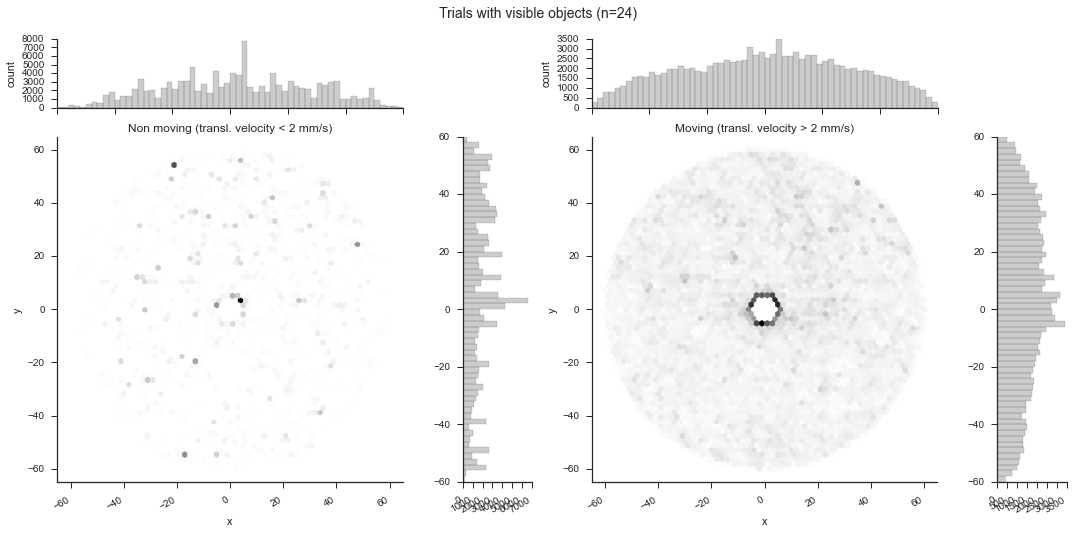

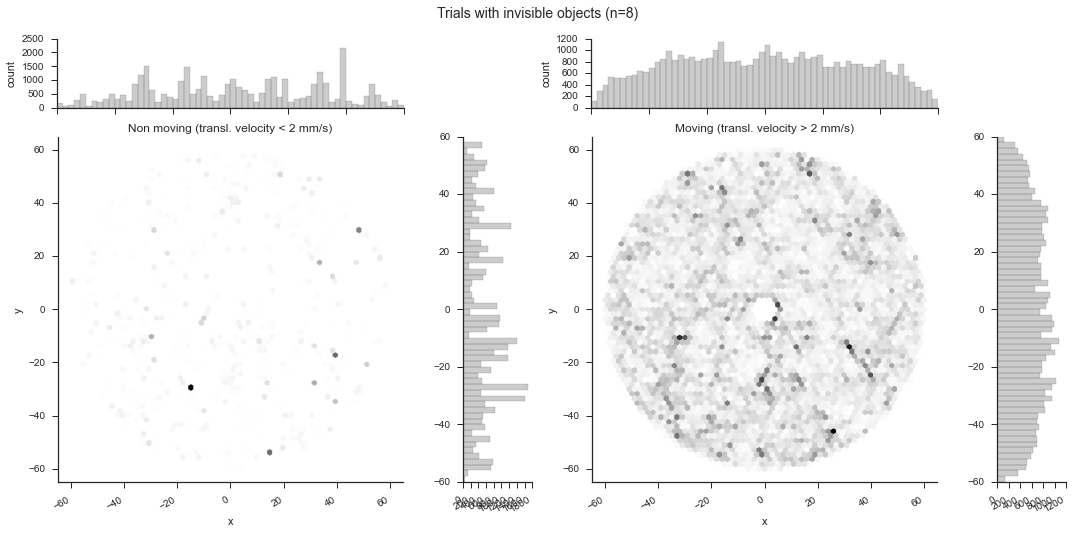

In [142]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

nTrials = (nTrialsVI,nTrialsIN)

for indcond, condition in enumerate(['visible', 'invisible']):
    querystring = '(trialtype == "' + condition + '")'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')
    vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()

    movingall = vT>vTransTH

    # make plot
    noNans = ~np.isnan(xPosMAall)
    hexplotfig = residencyWithHistograms_splitOnWalking(
        xPosMAall[noNans], yPosMAall[noNans], movingall[noNans], arenaRad, numBins, vTransTH,
        'Trials with ' + condition + ' objects (n=' + str(nTrials[indcond]) + ')')
    
    try:
        mkdir(analysisDir + 'residencyPlots/')
    except:
        print('Plot directory already exists')
        
    hexplotfig.savefig(analysisDir + 'residencyPlots/'  + genotypeSex + '_' + condition
                        + '_residencyMA_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

Plot directory already exists


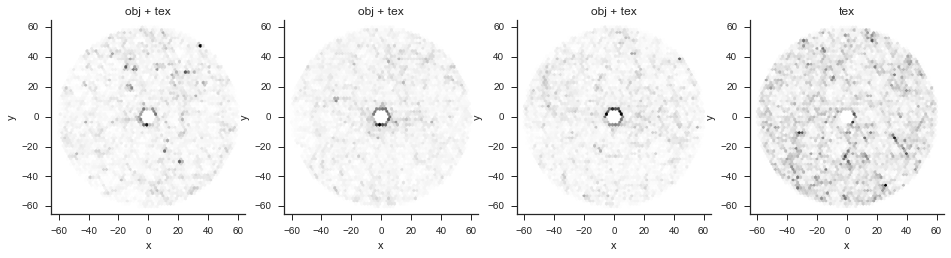

In [143]:
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

hexplotfig = plt.figure(figsize=(16,4))
for trial, condition in enumerate(trialName):
    querystring = '(trial == ' + str(trial+1) + ') & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    ax = hexplotfig.add_subplot(1,4,trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
    plt.xlabel('x'); plt.ylabel('y')
    ax.set_xlim(-arenaRad-5, arenaRad+5); ax.set_ylim(-arenaRad-5, arenaRad+5)
    ax.set_title(trialName[trial])
    ax.set_aspect('equal')
    myAxisTheme(ax)

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### 1D resiceny (along readial distance from object)

Plot directory already exists


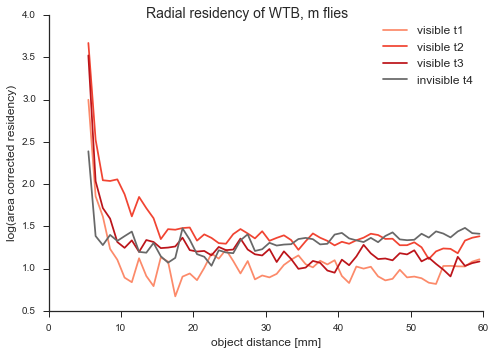

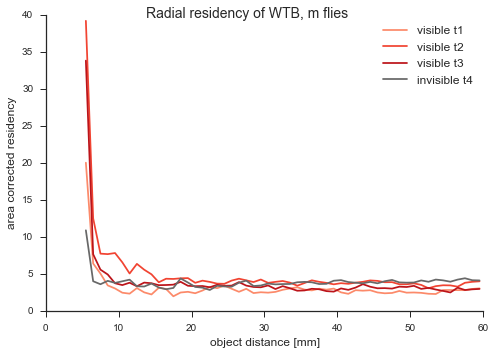

In [144]:
movementFilter = 'moving > 0'
numBins = 55
histRange = (5,arenaRad)

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')

# log residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, keyind_xPos, keyind_yPos, movementFilter,
                               visibilityState, numBins, histRange,1, True)
myAxisTheme(radResPlt)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidency_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

# linear residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, keyind_xPos, keyind_yPos, movementFilter,
                               visibilityState, numBins, histRange,1, False)
myAxisTheme(radResPlt)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidency_lin_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

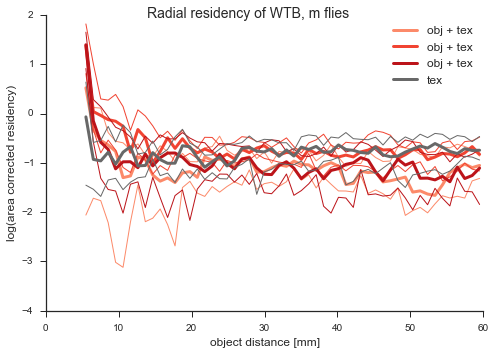

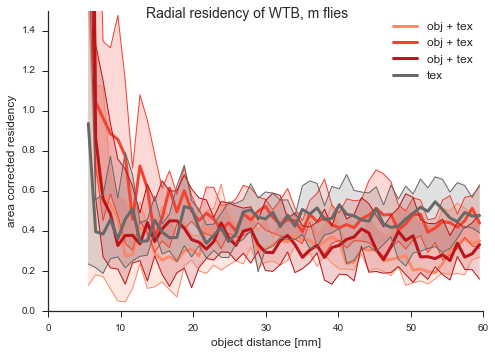

In [149]:
movementFilter = 'moving > 0'
numBins = 55
histRange = (5,arenaRad)
varStyle = 'iqr' #'std', 'iqr' 'dotplot'
fill = False

# log residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidencyWithVar_df(radResPlt, FOAllFlies_df, flyIDs, keyind_xPos, keyind_yPos, movementFilter,
                                      visibilityState, numBins, histRange, 1, True, varStyle, fill, trialName)
myAxisTheme(radResPlt)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidencyVar_'+varStyle+'_log_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

# linear residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidencyWithVar_df(radResPlt, FOAllFlies_df, flyIDs, keyind_xPos, keyind_yPos, movementFilter,
                                      visibilityState, numBins, histRange, 1, False, varStyle, True, trialName)
myAxisTheme(radResPlt)
radResPlt.set_ylim(0,1.5)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### TODO: plot 1D residency as per-fly histogram for the 4 trials

## Distance vs. relative heading

#### 2D (polar) residency: heading vs. distance

Plot directory already exists
Plot directory already exists
Plot directory already exists
Plot directory already exists


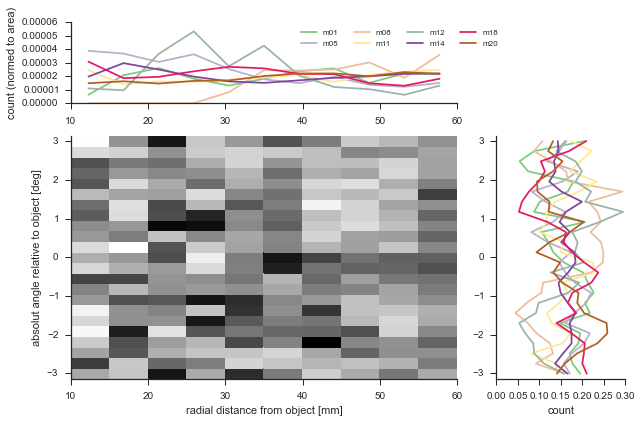

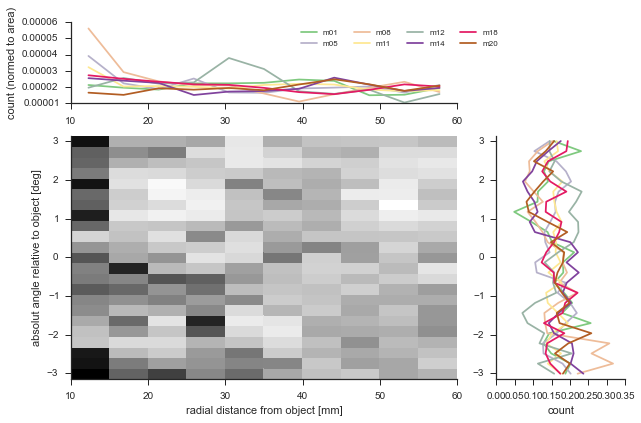

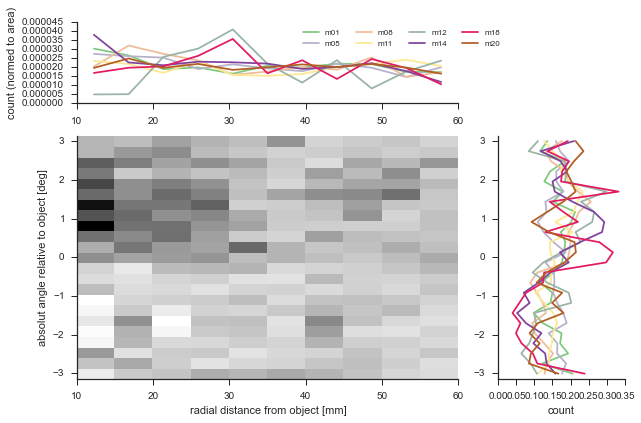

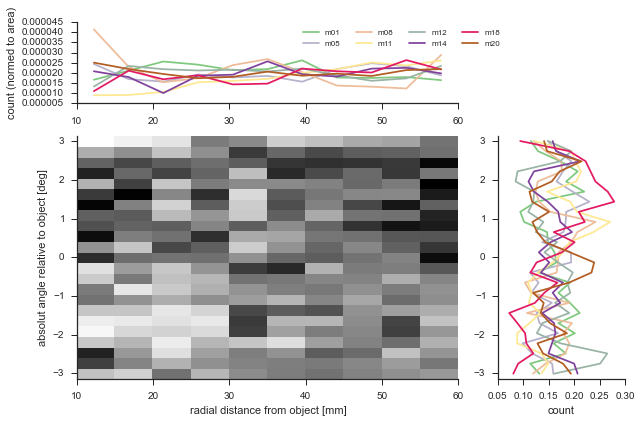

In [150]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray,
                                           objDistMAall,gammaFullall)
    
    try:
        mkdir(analysisDir + 'headingVsDistance/')
    except:
        print('Plot directory already exists')
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

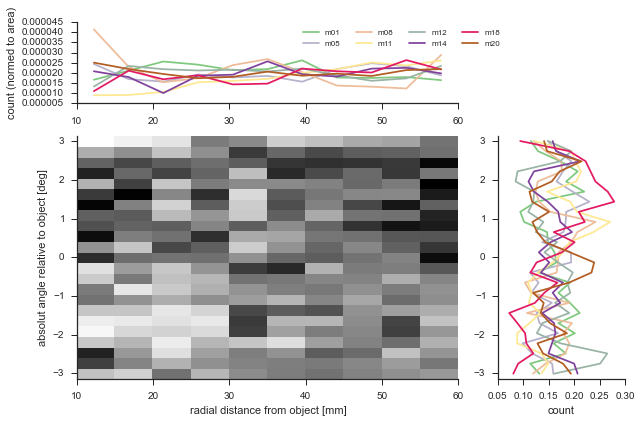

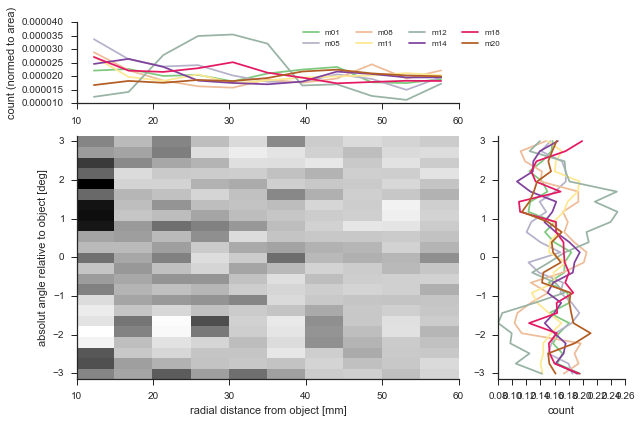

In [151]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

for ttind,trialtype in enumerate(list(set(visibilityState))):
    querystring = '(trialtype == "'+trialtype+'")'+\
        '& (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray,
                                           objDistMAall,gammaFullall)
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

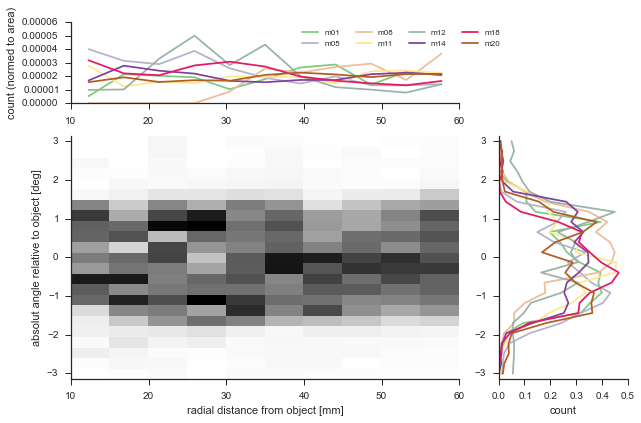

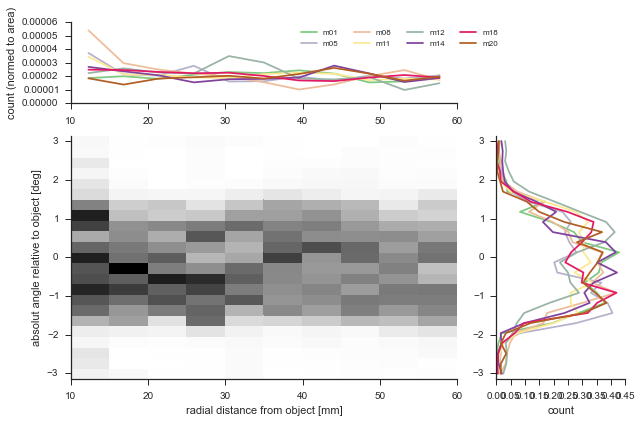

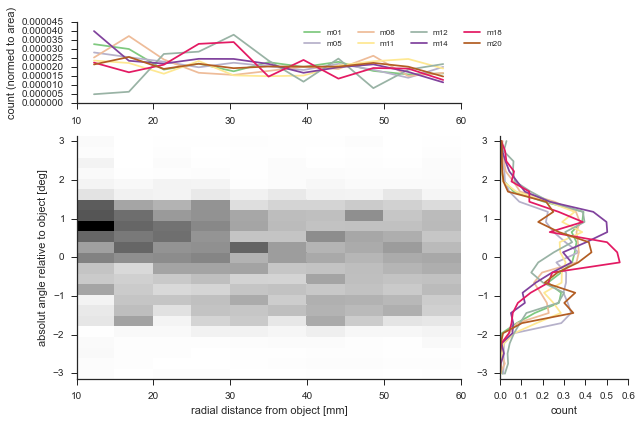

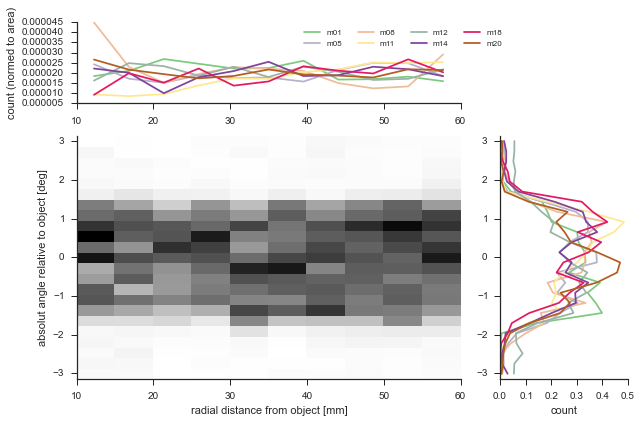

In [153]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)
    d_objDist = np.hstack((0, np.diff(np.convolve(objDistMAall, np.ones((7,))/7, mode='same'))))

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray[d_objDist<0],
                                           objDistMAall[d_objDist<0],gammaFullall[d_objDist<0])
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_apr_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

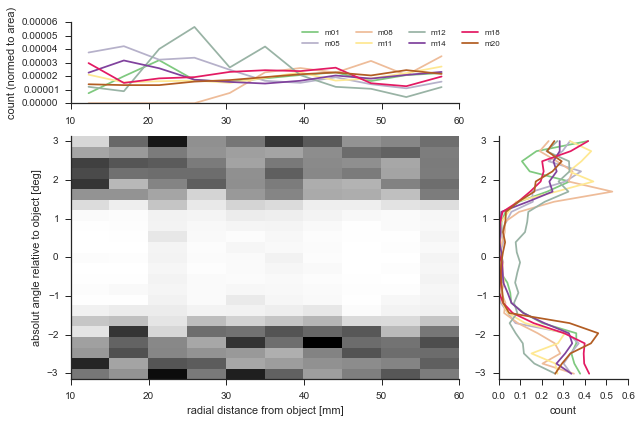

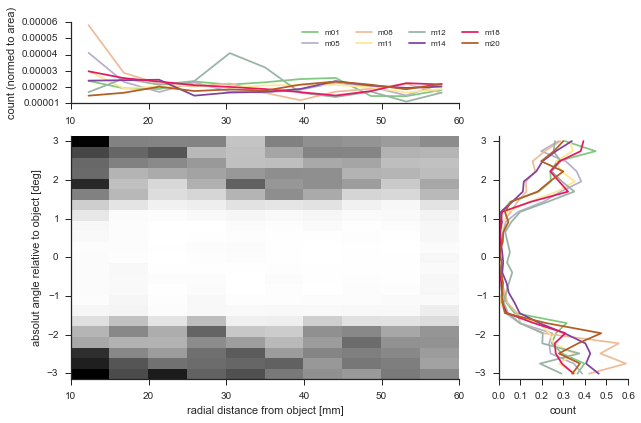

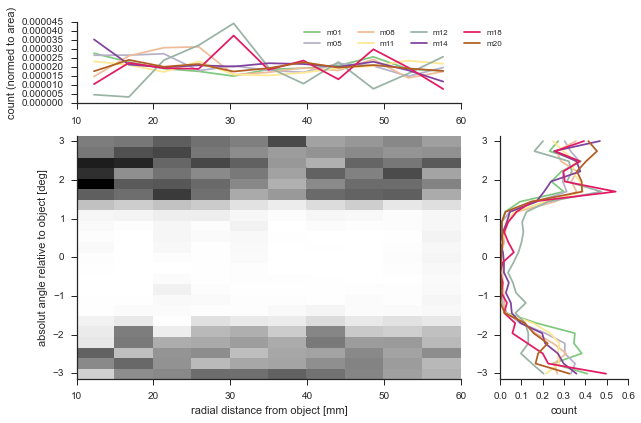

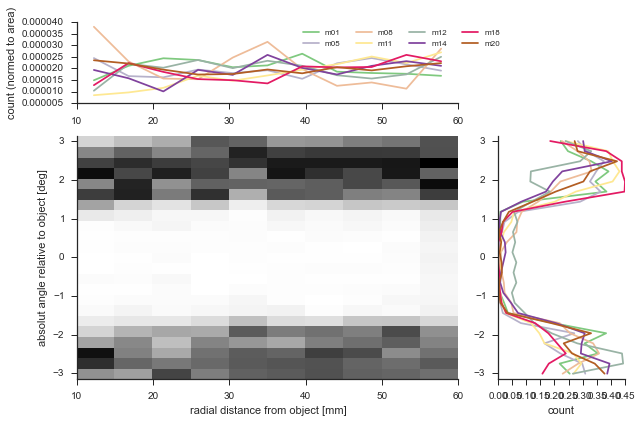

In [154]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)
    d_objDist = np.hstack((0, np.diff(np.convolve(objDistMAall, np.ones((7,))/7, mode='same'))))

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray[d_objDist>0],
                                           objDistMAall[d_objDist>0],gammaFullall[d_objDist>0])
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_dep_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

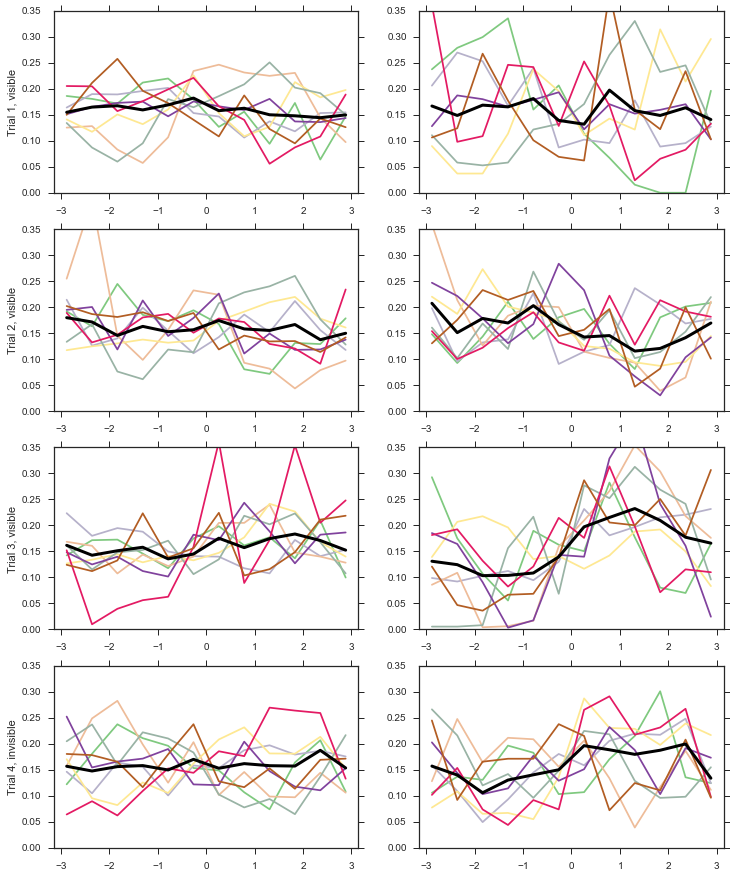

In [155]:
# plot parameter
distBins = 11
angleBins = 12
angleEdges = np.linspace(-np.pi, np.pi, angleBins)

angleFig = plt.figure(figsize=(12,15))

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    numFlies = len(flyIDs)
    flyCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=numFlies), cmap='Accent')

    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    minDist = 10
    maxDist = 30
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    sbplt = angleFig.add_subplot(4,2,ttind*2+1)

    for fly in range(numFlies):
        n, edges = np.histogram(gammaFullall[flyIDallarray == flyIDs[fly]],
                                range=(min(angleEdges), max(angleEdges)), bins=angleBins, normed=True)
        edgeCenteres = edges[:-1]+np.mean(np.diff(edges))/2
        sbplt.plot(edgeCenteres, n, color=flyCMap.to_rgba(fly))
        
    n, edges = np.histogram(gammaFullall, range=(min(angleEdges),
                            max(angleEdges)), bins=angleBins, normed=True)
    sbplt.plot(edgeCenteres, n, color='k',linewidth = 3)
        
    sbplt.set_ylabel('Trial '+str(ttind+1)+', '+trialtype)
    sbplt.set_xlim(min(angleEdges), max(angleEdges))
    sbplt.set_ylim(0, 0.35)
    
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    minDist = 30
    maxDist = 50
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    sbplt = angleFig.add_subplot(4,2,ttind*2+2)

    for fly in range(numFlies):
        n, edges = np.histogram(gammaFullall[flyIDallarray == flyIDs[fly]],
                                range=(min(angleEdges), max(angleEdges)), bins=angleBins, normed=True)
        edgeCenteres = edges[:-1]+np.mean(np.diff(edges))/2
        sbplt.plot(edgeCenteres, n, color=flyCMap.to_rgba(fly))

    n, edges = np.histogram(gammaFullall, range=(min(angleEdges),
                            max(angleEdges)), bins=angleBins, normed=True)
    sbplt.plot(edgeCenteres, n, color='k',linewidth = 3)
    
    sbplt.set_xlim(min(angleEdges), max(angleEdges))
    sbplt.set_ylim(0, 0.35)

    

## Analysis of steering maneuvres and their relationship with the object location

### Turnrate relative to object distance

Plot directory already exists


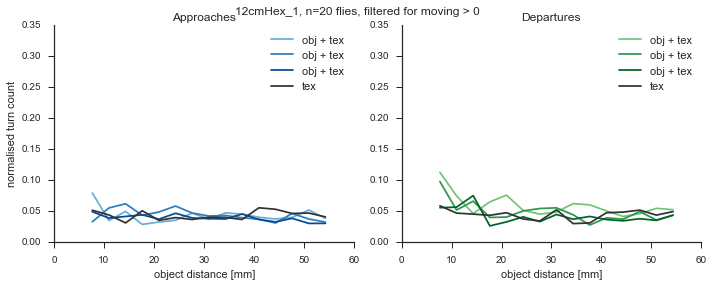

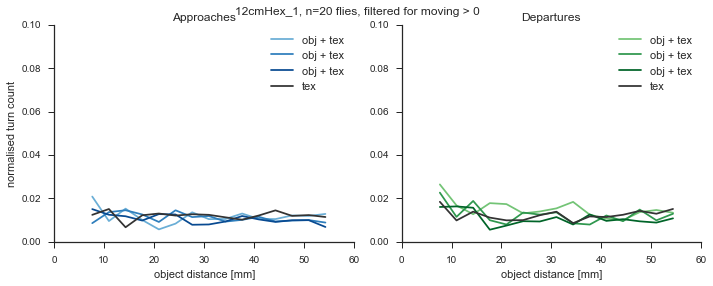

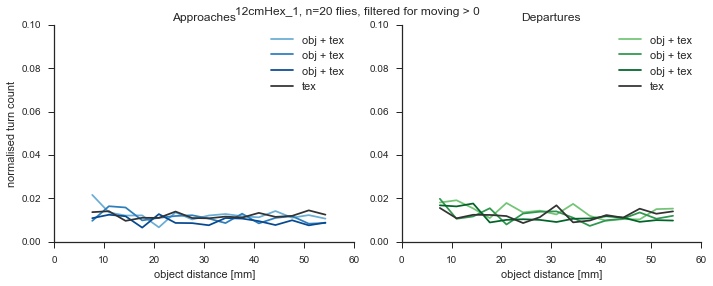

In [14]:
numBins = 15#10
useTurnIndex = False
movementFilter='moving > 0'

try:
    mkdir(analysisDir + 'turnRates/')
except:
    print('Plot directory already exists')

useTurnChange = 0

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.35)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
            + '_turnRatePerDistance_aboveTH'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

useTurnChange = 1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
            + '_turnRatePerDistance_turnStart'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

useTurnChange = -1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
            + '_turnRatePerDistance_turnEnd'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

## Change in rel. object heading before and after turns
###    --> generally decreasing?
###    --> bin values over different distance rings

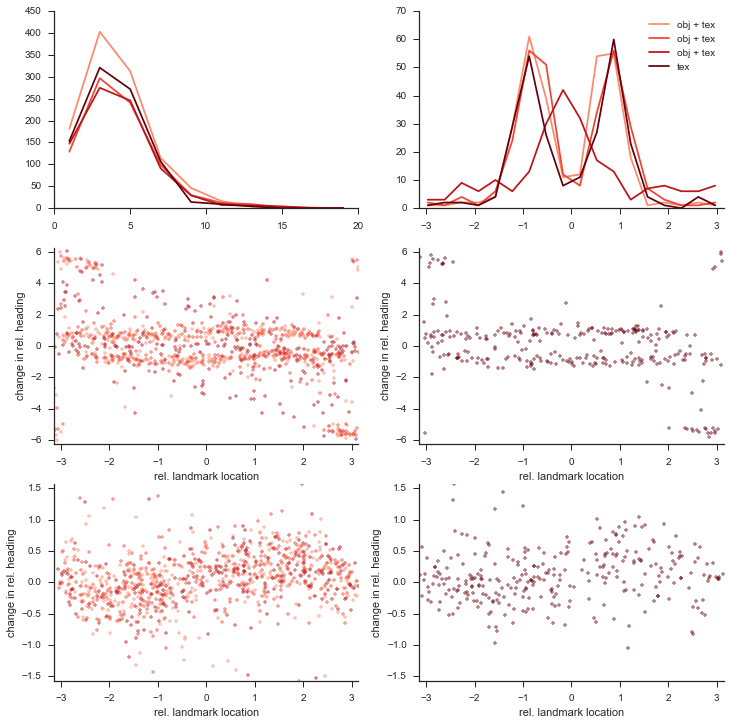

In [39]:
arenaRad = 60
useTurnIndex = False
useTurnChange = 1 #1 -- start of turn, -1 -- end of turn
movementFilter = 'moving > 0'
numVisTrials = 3
numInvTrials = 1

# Find turnTH over all flies
querystring = '('+movementFilter+') & (objectDistance>6)'
vRot = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_vR:keyind_vR+1]).squeeze()

if useTurnIndex:
    vtrans = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_vT:keyind_vT+1]).squeeze()
    vRot_filt = np.convolve(vRot/vtrans, np.ones((5,))/5, mode='same')
    vRot_filt[np.isinf(abs(vRot_filt))] = 0.0
else:
    vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')

turnTH_pos = 3*np.nanstd(vRot_filt[vRot_filt >= 0])
turnTH_neg = -3*np.nanstd(vRot_filt[vRot_filt <= 0])
turnTH = 3*np.nanstd(abs(vRot_filt))

turnEffectFig = plt.figure(figsize=(12,12))
turnLenghtPlt = turnEffectFig.add_subplot(321)
deltaHeadPlt = turnEffectFig.add_subplot(322)
visHeadVsChangePlt = turnEffectFig.add_subplot(323)
invHeadVsChangePlt = turnEffectFig.add_subplot(324)
turnLocPltPre = turnEffectFig.add_subplot(325)
turnLocPltPost = turnEffectFig.add_subplot(326)

visTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numVisTrials), cmap='Reds')
invTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numInvTrials), cmap='Greys')
trialCMap = [visTrialCMap.to_rgba(trial) for trial in range(4)]
trialCMap.append(invTrialCMap.to_rgba(0))

# Trial/fly specific values
for trial in range(1,5):

    querystring = '(trial==' + str(trial) + ') & (' + movementFilter + ') & (objectDistance>10)& (objectDistance<55)'
    xPosTrial = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1]).squeeze()
    yPosTrial = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1]).squeeze()
    vRotTrial = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_vR:keyind_vR+1]).squeeze()
    gammaFullTrial = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_gamful:keyind_gamful+1]).squeeze()
    gammaTrial = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_gam:keyind_gam+1]).squeeze()


    objDistTrial, thetaTrial = cartesian2polar(xPosTrial, yPosTrial)

    if useTurnIndex:
        vtrans = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_vT:keyind_vT+1]).squeeze()
        vRotTrial_filt = np.convolve(vRotTrial/vtrans, np.ones((5,))/5, mode='same')
    else:
        vRotTrial_filt = np.convolve(vRotTrial, np.ones((5,))/5, mode='same')

    # separate approaches and departures
    d_objDist = np.hstack((0, np.diff(objDistTrial)))
    pts_apr = d_objDist < 0
    pts_dep = d_objDist > 0

    turns = (abs(vRotTrial_filt) > turnTH).astype('int')
    tst = np.zeros(len(turns))
    tst[1:] = np.diff(turns) == useTurnChange

    turnsL = (vRotTrial_filt > turnTH_pos).astype('int')
    tstL = np.zeros(len(turnsL))
    tstL[1:] = np.diff(turnsL) == useTurnChange

    turnsR = (vRotTrial_filt < turnTH_neg).astype('int')
    tstR = np.zeros(len(turnsR))
    tstR[1:] = np.diff(turnsR) == useTurnChange
    
    #compute turn length
    turnT = np.zeros(sum(tst))
    #interTT = np.zeros(sum(tst))
    currTurn = 0
    turnStartInds = np.where(tst>0)[0]
    for tpt in range(len(turnStartInds)):
        ctpt = turnStartInds[tpt]
        while(turns[ctpt].astype('bool') == 1):
            currTurn += 1
            ctpt += 1
        turnT[tpt] = currTurn
        currTurn = 0
    
    #make plots
    preWdw = -2
    postWdw = 8
    
    xRange = -np.pi,np.pi
    yRange = -2*np.pi,2*np.pi
    yRange2 = -0.5*np.pi,0.5*np.pi
    
    turnStMask = tst.astype('bool')
    turnStMaskSham = tst.astype('bool')
    np.random.shuffle(turnStMaskSham)
    
    hist, bin_edges = np.histogram(turnT,range=(0,20))
    turnLenghtPlt.plot(bin_edges[:-1]+np.diff(bin_edges)/2,hist,color=trialCMap[trial-1])
    turnLenghtPlt.set_xlim(0,20)
    myAxisTheme(turnLenghtPlt)
    
    deltaHead = gammaFullTrial[np.roll(turnStMask,postWdw)]-gammaFullTrial[np.roll(turnStMask,preWdw)]
    deltaHeadSham = gammaFullTrial[np.roll(turnStMaskSham,postWdw)]-gammaFullTrial[np.roll(turnStMaskSham,preWdw)]
    
    hist, bin_edges = np.histogram(deltaHead,range=(-np.pi,np.pi),bins=18)
    deltaHeadPlt.plot(bin_edges[:-1]+np.diff(bin_edges)/2,hist,color=trialCMap[trial-1])
    deltaHeadPlt.set_xlim(-np.pi, np.pi)
    myAxisTheme(deltaHeadPlt)
    
    #turnStMask = np.roll(turnStMask,34)
    if(trial < 4):
        visHeadVsChangePlt.plot(gammaFullTrial[turnStMask],deltaHead,'.',alpha=0.5,color=trialCMap[trial-1])
        visHeadVsChangePlt.set_ylabel('change in rel. heading')
        visHeadVsChangePlt.set_xlabel('rel. landmark location')
        visHeadVsChangePlt.set_xlim(xRange)
        visHeadVsChangePlt.set_ylim(yRange)
        myAxisTheme(visHeadVsChangePlt)
    else:
        invHeadVsChangePlt.plot(gammaFullTrial[turnStMask],deltaHead,'.',alpha=0.5,color=trialCMap[trial-1])
        invHeadVsChangePlt.set_ylabel('change in rel. heading')
        invHeadVsChangePlt.set_xlabel('rel. landmark location')
        invHeadVsChangePlt.set_xlim(xRange)
        invHeadVsChangePlt.set_ylim(yRange)
        myAxisTheme(invHeadVsChangePlt)

    #turnStMask = np.roll(turnStMask,34)
    if(trial < 4):
        turnLocPltPre.plot(gammaFullTrial[turnStMaskSham],deltaHeadSham,'.',alpha=0.5,color=trialCMap[trial-1])
        turnLocPltPre.set_ylabel('change in rel. heading')
        turnLocPltPre.set_xlabel('rel. landmark location')
        turnLocPltPre.set_xlim(xRange)
        turnLocPltPre.set_ylim(yRange2)
        myAxisTheme(turnLocPltPre)
    else:
        turnLocPltPost.plot(gammaFullTrial[turnStMaskSham],deltaHeadSham,'.',alpha=0.5,color=trialCMap[trial-1])
        turnLocPltPost.set_ylabel('change in rel. heading')
        turnLocPltPost.set_xlabel('rel. landmark location')
        turnLocPltPost.set_xlim(xRange)
        turnLocPltPost.set_ylim(yRange2)
        myAxisTheme(turnLocPltPost)


    #hist, bin_edges = np.histogram(gammaTrial[np.roll(turnStMask,preWdw)],range=(0,np.pi),bins=18)
    #turnLocPltPre.plot(bin_edges[:-1]+np.diff(bin_edges)/2,hist,color=trialCMap[trial-1])
    #turnLocPltPre.set_xlim(0,np.pi)
    #myAxisTheme(turnLocPltPre)
    
    #hist, bin_edges = np.histogram(gammaTrial[np.roll(turnStMask,postWdw)],range=(0,np.pi),bins=18)
    #turnLocPltPost.plot(bin_edges[:-1]+np.diff(bin_edges)/2,hist,color=trialCMap[trial-1])
    #turnLocPltPost.set_xlim(0,np.pi)
    #myAxisTheme(turnLocPltPost)

deltaHeadPlt.legend([trialName[trial-1] for trial in range(1,5)])

## Count number of visits (enter radius around landmark)

In [30]:
def countVisits_df(visitRad,fly,trial,allFlies_df,keyind_xPos,keyind_yPos,keyind_gam):
    
    querystring = '(trial==' + str(trial) + ') & (flyID == "'+flyIDs[fly]+'")'
    xPosTrial = np.asarray(allFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1]).squeeze()
    yPosTrial = np.asarray(allFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1]).squeeze()
    gammaTrial = np.asarray(allFlies_df.query(querystring).iloc[:, keyind_gam:keyind_gam+1]).squeeze()

    objDistTrial, thetaTrial = cartesian2polar(xPosTrial, yPosTrial)

    inside = (objDistTrial<visitRad).astype('int')
    time = np.linspace(0,600,len(xPosTrial))

    entries = np.zeros(len(inside))
    entries[1:] = np.diff(inside) == 1

    exits = np.zeros(len(inside))
    exits[1:] = np.diff(inside) == -1

    entryTime = time[entries.astype('bool')]
    exitTime = time[exits.astype('bool')]
    if len(entryTime) != len(exitTime):
        visitT = exitTime[0:min(sum(exits),sum(entries))] - entryTime[0:min(sum(exits),sum(entries))]
    else:
        visitT = exitTime - entryTime
    
    return entries, exits, visitT
    

Analysis directory already exists.


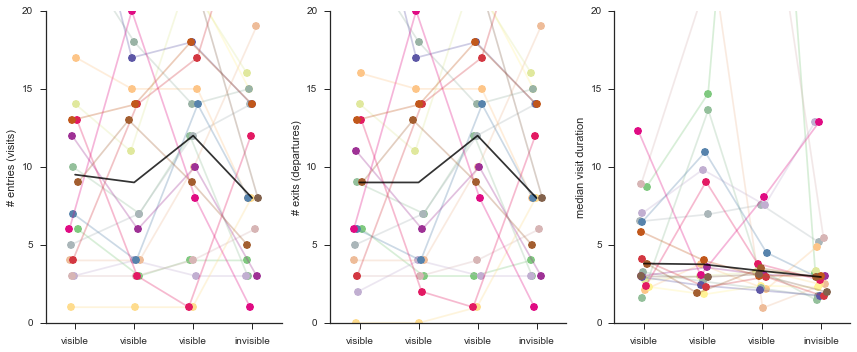

In [48]:
visitRad = 20
numtrials = 4

numEntries = np.zeros((numFlies,numtrials))
numExits = np.zeros((numFlies,numtrials))
lengthVisit = np.zeros((numFlies,numtrials))
jitter = np.zeros((numFlies,numtrials))

visitFig = plt.figure(figsize=(12,5))

numEntryPlt = visitFig.add_subplot(131)
plt.xticks([1,2,3,4],visibilityState, rotation='horizontal')
numExitPlt = visitFig.add_subplot(132)
plt.xticks([1,2,3,4],visibilityState, rotation='horizontal')
meanVisitPlt = visitFig.add_subplot(133)
plt.xticks([1,2,3,4],visibilityState, rotation='horizontal')

for fly in range(numFlies):
    for trial in range(numtrials):

        tJitter = np.random.uniform(-0.1, 0.1)
        jitter[fly,trial] = tJitter
        
        entries, exits, visitDuration = countVisits_df(visitRad,fly,trial+1,FOAllFlies_df,keyind_xPos,keyind_yPos,keyind_gam)
        numEntry = sum(entries)
        numExit = sum(exits)
        
        numEntries[fly,trial] = numEntry
        numExits[fly,trial] = numExit
        lengthVisit[fly,trial] = np.nanmedian(visitDuration)

        numEntryPlt.plot(trial+1+tJitter,numEntry,'.',markersize=15,color=flyCMap.to_rgba(fly))
        numExitPlt.plot(trial+1+tJitter,numExit,'.',markersize=15,color=flyCMap.to_rgba(fly))
        meanVisitPlt.plot(trial+1+tJitter,np.nanmedian(visitDuration),'.',markersize=15,color=flyCMap.to_rgba(fly))
        
    numEntryPlt.plot(range(1,numtrials+1)+jitter[fly,:],numEntries[fly,:],
                     '-',markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    numExitPlt.plot(range(1,numtrials+1)+jitter[fly,:] ,numExits[fly,:],'-',
                    markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    meanVisitPlt.plot(range(1,numtrials+1)+jitter[fly,:],lengthVisit[fly,:],'-',
                      markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)

#plot average response
numEntryPlt.plot(range(1,5),np.nanmedian(numEntries,axis=0),color='k',alpha=0.8)
numExitPlt.plot(range(1,5),np.nanmedian(numExits,axis=0),color='k',alpha=0.8)
meanVisitPlt.plot(range(1,5),np.nanmedian(lengthVisit,axis=0),color='k',alpha=0.8)

numEntryPlt.set_ylabel('# entries (visits)')
numEntryPlt.set_ylim(0,20)
numEntryPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(numEntryPlt)

numExitPlt.set_ylabel('# exits (departures)')
numExitPlt.set_ylim(0,20)
numExitPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(numExitPlt)

meanVisitPlt.set_ylabel('median visit duration')
meanVisitPlt.set_ylim(0,20)
meanVisitPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(meanVisitPlt)

visitFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'visitAnalysis' + sep)
except OSError:
    print('Analysis directory already exists.')

visitFig.savefig(analysisDir + 'visitAnalysis/'  + genotypeSex
                   + '_visitsInRad'+str(visitRad)+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

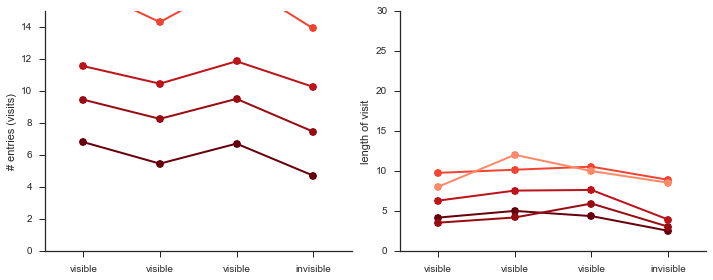

In [34]:
visitRadDists = [10,15,20,30,40]
numtrials = 4

visitFig = plt.figure(figsize=(10,4))
numEntryPlt = visitFig.add_subplot(121)
plt.xticks([1,2,3,4],visibilityState, rotation='horizontal')
visitDurPlt = visitFig.add_subplot(122)
plt.xticks([1,2,3,4],visibilityState, rotation='horizontal')

distanceCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=min(visitRadDists), vmax=60), cmap='Blues_r')
distanceCMap2 = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=min(visitRadDists), vmax=60), cmap='Reds_r')

for dist in range(len(visitRadDists)):
    visitRad = visitRadDists[dist]
    numEntries = np.zeros((numFlies,numtrials))
    lengthVisit = np.zeros((numFlies,numtrials))

    for fly in range(numFlies):
        for trial in range(numtrials):

            entries, exits, visitDuration = countVisits_df(visitRad,fly,trial+1,FOAllFlies_df,keyind_xPos,keyind_yPos,keyind_gam)
            numEntry = sum(entries)

            numEntries[fly,trial] = numEntry
            lengthVisit[fly,trial] = np.nanmedian(visitDuration)

    #plot average response
    #numEntryPlt.plot(range(1,5),np.nanmedian(numEntries,axis=0),'.',
    #                 color=distanceCMap.to_rgba(visitRad),markersize = 15)
    #numEntryPlt.plot(range(1,5),np.nanmedian(numEntries,axis=0),
    #                 color=distanceCMap.to_rgba(visitRad),linewidth = 2)
    numEntryPlt.plot(range(1,5),np.nanmean(numEntries,axis=0),'.',
                     color=distanceCMap2.to_rgba(visitRad),markersize = 15)
    numEntryPlt.plot(range(1,5),np.nanmean(numEntries,axis=0),
                     color=distanceCMap2.to_rgba(visitRad),linewidth = 2)
    
    #visitDurPlt.plot(range(1,5),np.nanmedian(lengthVisit,axis=0),'.',
    #                 color=distanceCMap.to_rgba(visitRad),markersize = 15)
    #visitDurPlt.plot(range(1,5),np.nanmedian(lengthVisit,axis=0),
    #                 color=distanceCMap.to_rgba(visitRad),linewidth = 2)
    visitDurPlt.plot(range(1,5),np.nanmean(lengthVisit,axis=0),'.',
                     color=distanceCMap2.to_rgba(visitRad),markersize = 15)
    visitDurPlt.plot(range(1,5),np.nanmean(lengthVisit,axis=0),
                     color=distanceCMap2.to_rgba(visitRad),linewidth = 2)

numEntryPlt.set_ylabel('# entries (visits)')
numEntryPlt.set_ylim(0,15)
numEntryPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(numEntryPlt)

visitDurPlt.set_ylabel('length of visit')
visitDurPlt.set_ylim(0,30)
visitDurPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(visitDurPlt)

visitFig.tight_layout()

visitFig.savefig(analysisDir + 'visitAnalysis/'  + genotypeSex
                   + '_entiresPerRad_mean_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

In [35]:
def visitTime_df(visitRad,fly,trial,allFlies_df,keyind_xPos,keyind_yPos):
    
    querystring = '(trial==' + str(trial) + ') & (flyID == "'+flyIDs[fly]+'")'
    xPosTrial = np.asarray(allFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1]).squeeze()
    yPosTrial = np.asarray(allFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1]).squeeze()

    objDistTrial, thetaTrial = cartesian2polar(xPosTrial, yPosTrial)

    inside = (objDistTrial<visitRad).astype('int')
    time = np.linspace(0,600,len(xPosTrial))

    entries = np.zeros(len(inside))
    entries[1:] = np.diff(inside) == 1

    exits = np.zeros(len(inside))
    exits[1:] = np.diff(inside) == -1

    entryTime = time[entries.astype('bool')]
    exitTime = time[exits.astype('bool')]
    
    return entries, exits, time, entryTime, exitTime

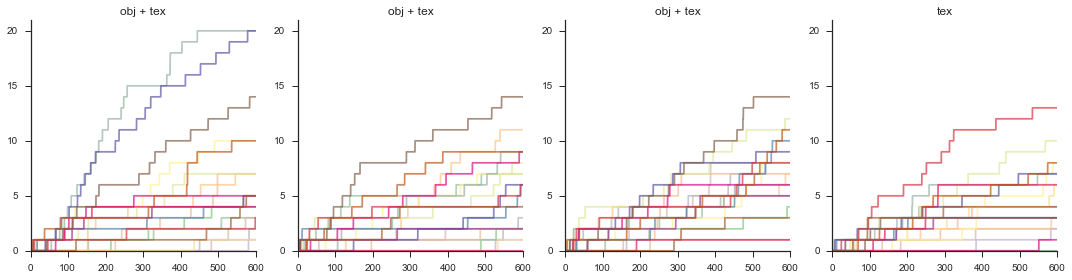

In [47]:
visitRad = 10
numtrials = 4

visitFig = plt.figure(figsize=(15,4))

maxVisit = 0
for trial in range(1,5):
    cumVisitPlt = visitFig.add_subplot(1,4,trial)

    for fly in range(numFlies):
        entries, exits, time, entryTime, exitTime = visitTime_df(visitRad,fly,trial,FOAllFlies_df,keyind_xPos,keyind_yPos)
        cumVisitPlt.plot(time,np.cumsum(entries),color=flyCMap.to_rgba(fly),alpha=0.7)
        maxVisit = max(maxVisit,sum(entries))
    
    cumVisitPlt.set_ylim(0,maxVisit+1)
    cumVisitPlt.set_title(trialName[trial-1])
    myAxisTheme(cumVisitPlt)

visitFig.tight_layout()

visitFig.savefig(analysisDir + 'visitAnalysis/'  + genotypeSex
                   + '_cumVisitPlt_visitRad'+str(visitRad)+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

## Polar coord maps of movement parameter

In [71]:
minDist = 10
maxDist = 55
distEdges = np.linspace(minDist, maxDist, 10)
angleEdges = np.linspace(0, np.pi, 9)
fullAngleEdges = np.linspace(-np.pi, np.pi, 24)
maxVals = (12.0,7.0, 1.0, 0.3) #(20.0,10.0, 1.5, 0.3)#

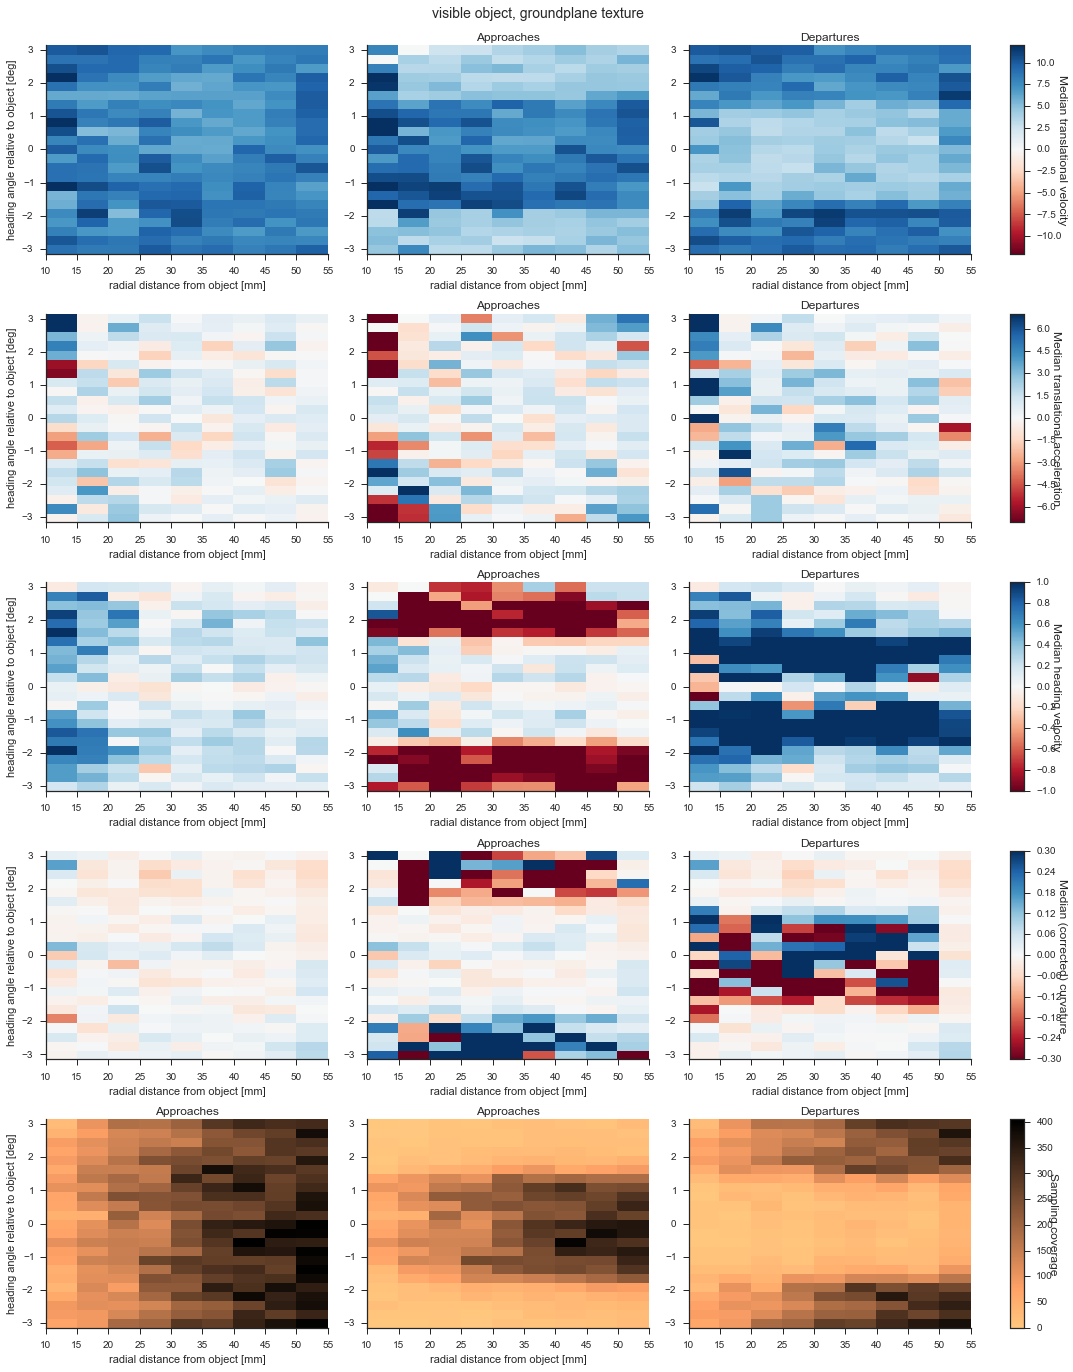

In [72]:
#for tind,trialtype in enumerate(visibilityState):
trial = 1
trialtype = 'visible'
querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

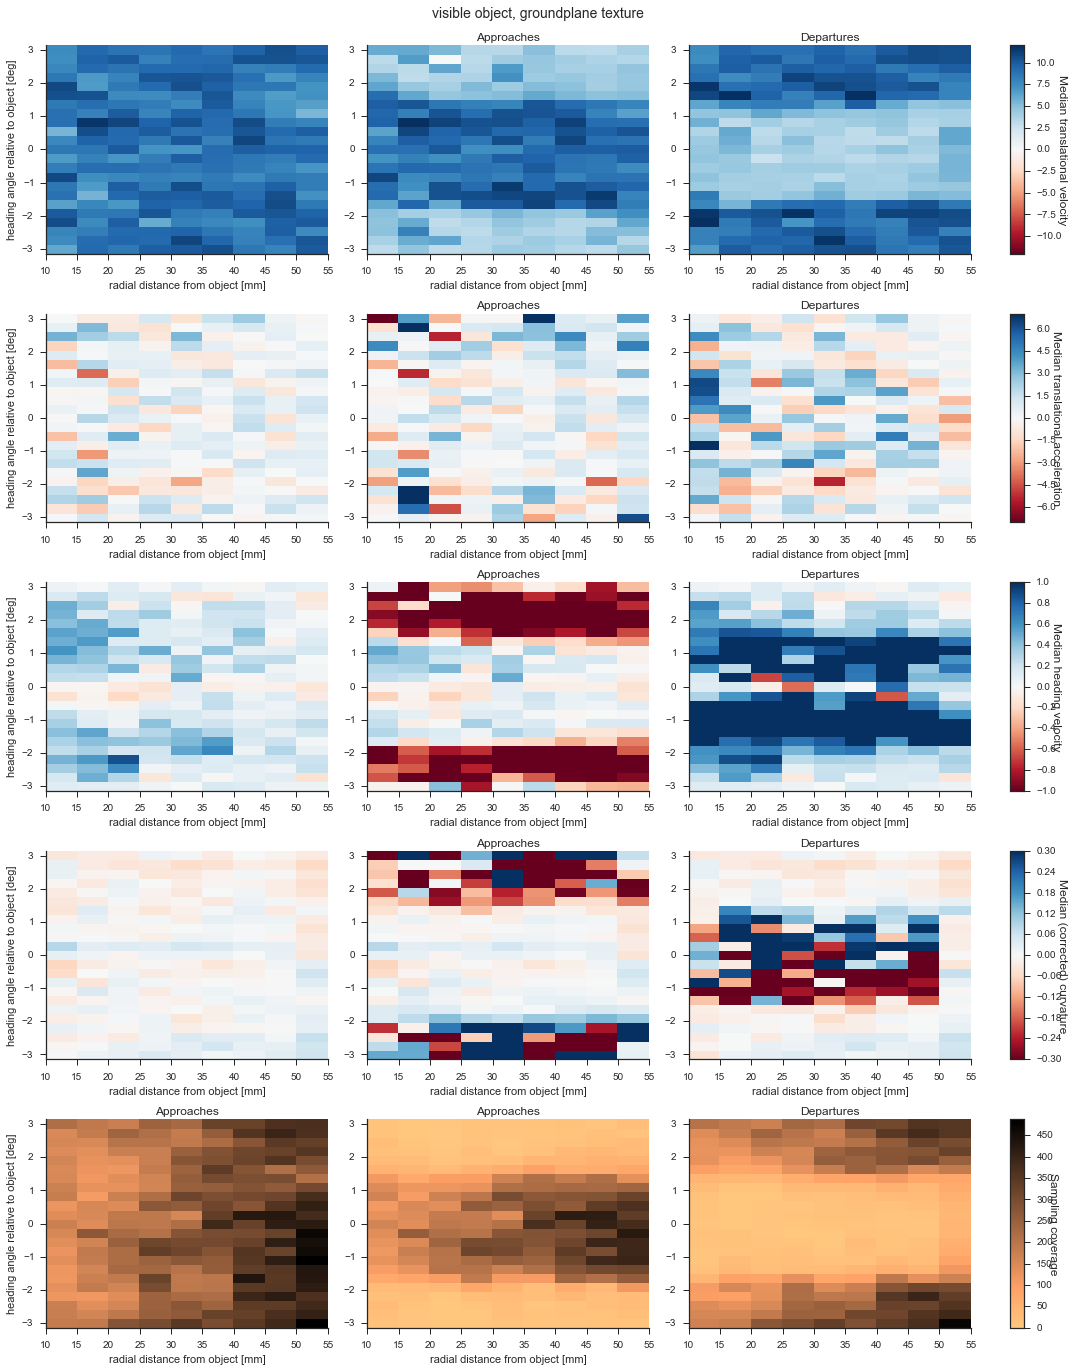

In [73]:
trialtype = 'visible'
trial = 2

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

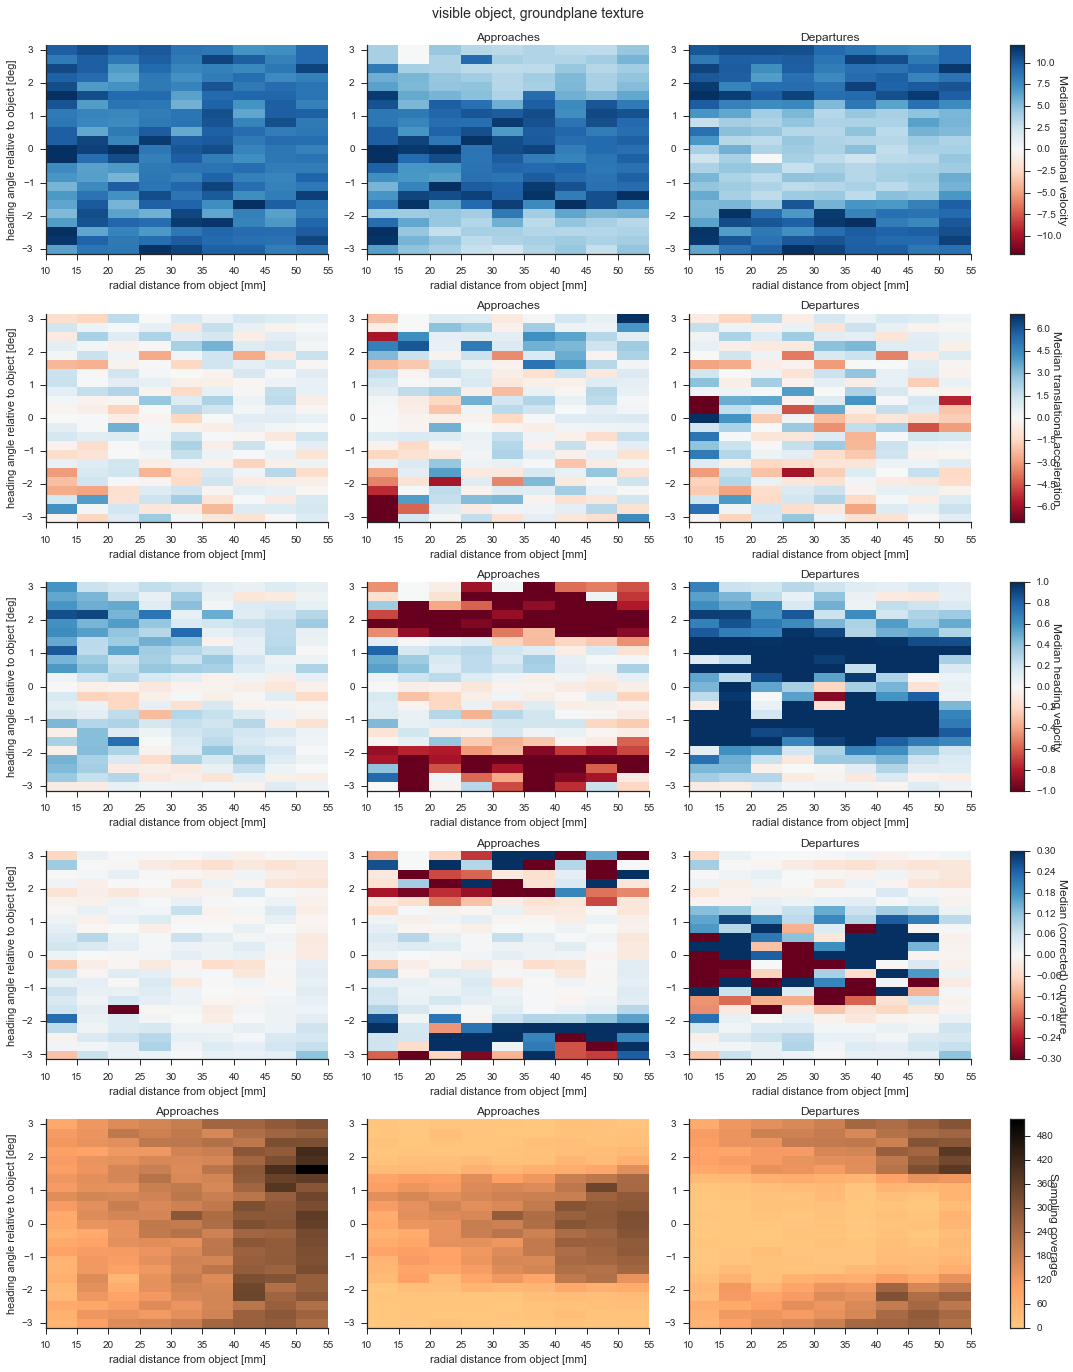

In [74]:
trialtype = 'visible'
trial = 3

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

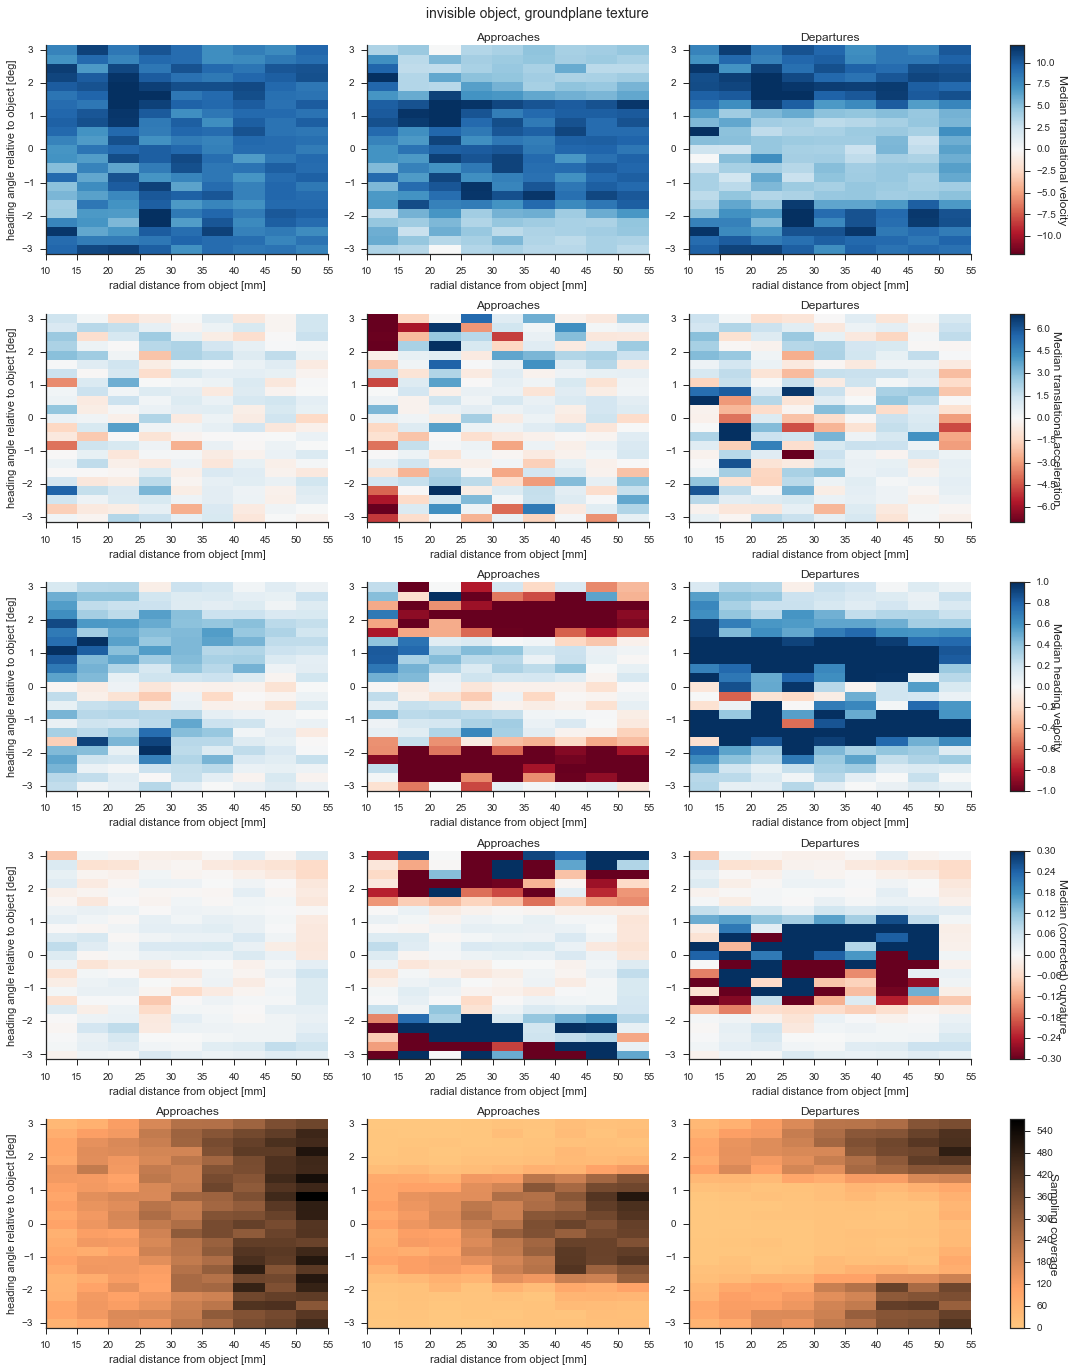

In [75]:
trialtype = 'invisible'
trial = 4

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

## Comparison between trials

Analysis directory already exists.


/Users/hannah/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


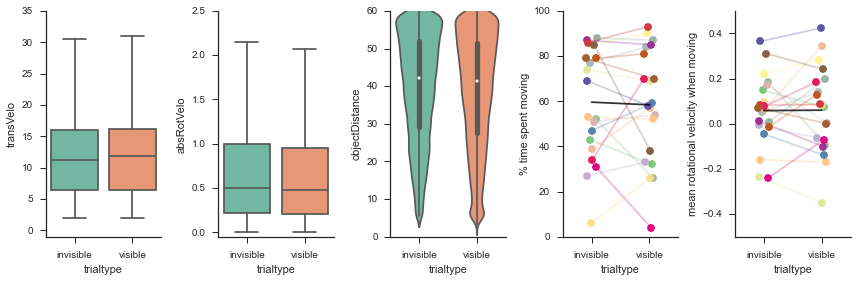

In [40]:
FOAllFliesMoving_df = FOAllFlies_df.query('(moving > 0)')
FOAllFliesMoving_df = FOAllFliesMoving_df[keylistLong]
FOAllFliesMoving_df.insert(0, 'absRotVelo', abs(FOAllFliesMoving_df['rotVelo']))

perTrialBP = plt.figure(figsize=(12,4))

perTrialBPvT = perTrialBP.add_subplot(151)
sns.boxplot(x='trialtype', y='transVelo', 
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvT.set_ylim(-1,35)
myAxisTheme(perTrialBPvT)

perTrialBPvR = perTrialBP.add_subplot(152)
sns.boxplot(x='trialtype', y='absRotVelo',
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvR.set_ylim(-0.05,2.5)
myAxisTheme(perTrialBPvR)

perTrialVPod = perTrialBP.add_subplot(153)
sns.violinplot(x='trialtype', y='objectDistance', data=FOAllFliesMoving_df,
               palette='Set2',sym='', bw=.1)
               #,inner='stick',  scale='count')
perTrialVPod.set_ylim(0,arenaRad)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,2))
rotationBias = np.zeros((numFlies,2))
randJitter = np.zeros((numFlies,2))

perFlyMovingPlt = perTrialBP.add_subplot(154)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')
perFlyRotBiasPlt = perTrialBP.add_subplot(155)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')

for fly in range(numFlies):
    for ttind,trialtype in enumerate(["visible","invisible"]):
        querystring = '(trialtype == "' + trialtype + '") & (flyID == "' + flyIDs[fly] +  '")'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')        
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,ttind] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,ttind] = np.mean(perFlyRot[perFlyMoving])
        randJitter[fly,ttind] = jitter
        perFlyMovingPlt.plot(ttind+1+jitter,percentMoving[fly,ttind],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyRotBiasPlt.plot(ttind+1+jitter,rotationBias[fly,ttind],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,3)+randJitter[fly,:] ,percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyRotBiasPlt.plot(range(1,3)+randJitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
#plot average response
perFlyMovingPlt.plot(range(1,3),np.mean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,3),np.mean(rotationBias,axis=0),color='k',alpha=0.8)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,2.5)
perFlyMovingPlt.set_xlabel('trialtype')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.5,0.5)
perFlyRotBiasPlt.set_xlim(0.5,2.5)
perFlyRotBiasPlt.set_xlabel('trialtype')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity when moving')
myAxisTheme(perFlyRotBiasPlt)

perTrialBP.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareTrialtypes' + sep)
except OSError:
    print('Analysis directory already exists.')

perTrialBP.savefig(analysisDir + 'compareTrialtypes/'  + genotypeSex
                   + '_visibleVSinvisible_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

Analysis directory already exists.


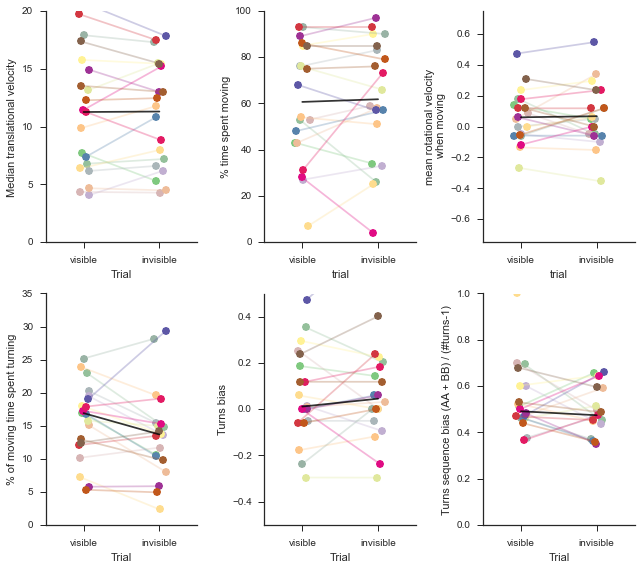

In [41]:
# make fly summary plot of residency:
arenaRad = 60
trialtypes = ["visible","invisible"]
minTurnDist = 5
numtrials = len(trialtypes)
minDist = 10
maxDist = 60

trialComparisonFig = plt.figure(figsize=(9,8))
gs = gridspec.GridSpec(2,3) #,width_ratios=[1,0.9])


# Top row plots: ...............................................................................................

# Plots of (a) percent of time spent moving, (b) rotational bias and (c) mean distance from object
percentMoving = np.zeros((numFlies,numtrials))
rotationBias = np.zeros((numFlies,numtrials))
jitter = np.zeros((numFlies,numtrials))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[0,1])
plt.xticks([1,2],trialtypes, rotation='horizontal')

perFlyRotBiasPlt = trialComparisonFig.add_subplot(gs[0,2])
plt.xticks([1,2],trialtypes, rotation='horizontal')


for fly in range(numFlies):
    for trial,trialtype in enumerate(trialtypes):

        tJitter = np.random.uniform(-0.1, 0.1)
        jitter[fly,trial] = tJitter
        
        querystring = '(trialtype == "' +trialtype+ '") & (flyID == "'+ flyIDs[fly] +'")'\
                        +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        querystring = '(trialtype == "' +trialtype+ '") & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                       +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')
        
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,trial] = np.nanmedian(perFlyRot)
        
        perFlyMovingPlt.plot(trial+1+tJitter,percentMoving[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))

        perFlyRotBiasPlt.plot(trial+1+tJitter,rotationBias[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
                
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+jitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    perFlyRotBiasPlt.plot(range(1,numtrials+1)+jitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)

    
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,numtrials+1),np.nanmean(rotationBias,axis=0),color='k',alpha=0.8)

# Beautify axes

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('trial')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.75,0.75)
perFlyRotBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyRotBiasPlt.set_xlabel('trial')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity \n when moving')
myAxisTheme(perFlyRotBiasPlt)

# Bottom row plots: ...............................................................................................

# Only include moving flies
querystring = '(moving > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 2*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -2*np.std(vRot_filt[vRot_filt<=0])

percentMoving = np.zeros((numFlies,numtrials))
perFlyTurnTH = np.zeros((numFlies,numtrials))
perFlyNumTurn = np.zeros((numFlies,numtrials))
perFlyTurnDir = np.zeros((numFlies,numtrials))
perFlyTurnSeqBias = np.zeros((numFlies,numtrials))

randJitter = np.zeros((numFlies,numtrials))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[0,0])
plt.xticks([1,2],trialtypes, rotation='horizontal')
perFlyTurnTHPlt = trialComparisonFig.add_subplot(gs[1,0])
plt.xticks([1,2],trialtypes, rotation='horizontal')
perFlyTurnDirPlt = trialComparisonFig.add_subplot(gs[1,1])
plt.xticks([1,2],trialtypes, rotation='horizontal')
perFlyTurnSeqBiasPlt = trialComparisonFig.add_subplot(gs[1,2])
plt.xticks([1,2],trialtypes, rotation='horizontal')

for fly in range(numFlies):
    for trial in range(numtrials):
        
        jitter = np.random.uniform(-0.1, 0.1)
        randJitter[fly,trial] = jitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'\
                      +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')

        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                      +'& (objectDistance >='+str(minDist)+') & (objectDistance <='+str(maxDist)+')'
        perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
        
        perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')
        
        turnMask = np.logical_or(perFlyRot_filt>turnTH_pos,perFlyRot_filt<turnTH_neg)
        turnLoc = np.where(turnMask>0)[0]
        turnStart = turnLoc[np.where(np.hstack((0,np.diff(turnLoc)))>minTurnDist)[0]]
        turnSide = np.sign(perFlyRot[turnStart])
        
        try:
            turnSeq = np.zeros(len(turnStart)-1)
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==0.5)[0]] = 2
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-0.5)[0]] = 3
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-1.5)[0]] = 0
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-2.5)[0]] = 1
            
            numBin = 4
            [n,edgs] = np.histogram(turnSeq,bins=numBin)
        
        except ValueError:
            print('Not enought turns in fly' + str(fly))
            n = np.ones(numBin)*np.nan
            
        perFlyTurnTH[fly,trial] = 100.0*(sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg))/max(1,len(perFlyRot_filt))
        #perFlyNumTurn[fly,trial] = len(turnStart)
        perFlyTurnDir[fly,trial] = np.nanmedian(perFlyRot)
        if sum(n)==0:
            perFlyTurnSeqBias[fly,trial] = np.nan
        else:
            perFlyTurnSeqBias[fly,trial] = float(sum(n[2:]))/sum(n)
        
        alphaVal = min(perFlyNumTurn[fly,trial]/3,1)
        
        percentMoving[fly,trial] = np.nanmedian(perFlyTra)
        
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnTHPlt.plot(trial+1+jitter,perFlyTurnTH[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyTurnDirPlt.plot(trial+1+jitter,perFlyTurnDir[fly,trial],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqBiasPlt.plot(trial+1+jitter,perFlyTurnSeqBias[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+randJitter[fly,:],percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)    
    perFlyTurnTHPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnTH[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnDirPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnDir[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnSeqBias[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyTurnTHPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnTH,axis=0),color='k',alpha=0.8)
perFlyTurnDirPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnDir,axis=0),color='k',alpha=0.8)
perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnSeqBias,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMovingPlt.set_ylim(0,20)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('Trial')
perFlyMovingPlt.set_ylabel('Median translational velocity')
myAxisTheme(perFlyMovingPlt)

perFlyTurnTHPlt.set_ylim(0,35)
perFlyTurnTHPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnTHPlt.set_xlabel('Trial')
perFlyTurnTHPlt.set_ylabel('% of moving time spent turning')
myAxisTheme(perFlyTurnTHPlt)

perFlyTurnDirPlt.set_ylim(-0.5,0.5)
perFlyTurnDirPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnDirPlt.set_xlabel('Trial')
perFlyTurnDirPlt.set_ylabel('Turns bias')
myAxisTheme(perFlyTurnDirPlt)

perFlyTurnSeqBiasPlt.set_ylim(0,1)
perFlyTurnSeqBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnSeqBiasPlt.set_xlabel('Trial')
perFlyTurnSeqBiasPlt.set_ylabel('Turns sequence bias (AA + BB) / (#turns-1)')
myAxisTheme(perFlyTurnSeqBiasPlt)

trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareTrialtypes' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir+'compareTrialtypes/'+genotype+'_'+flyIDs[0][0]
                   +'_trialtype_n'+str(len(flyIDs))+'.pdf', format='pdf')

Analysis directory already exists.


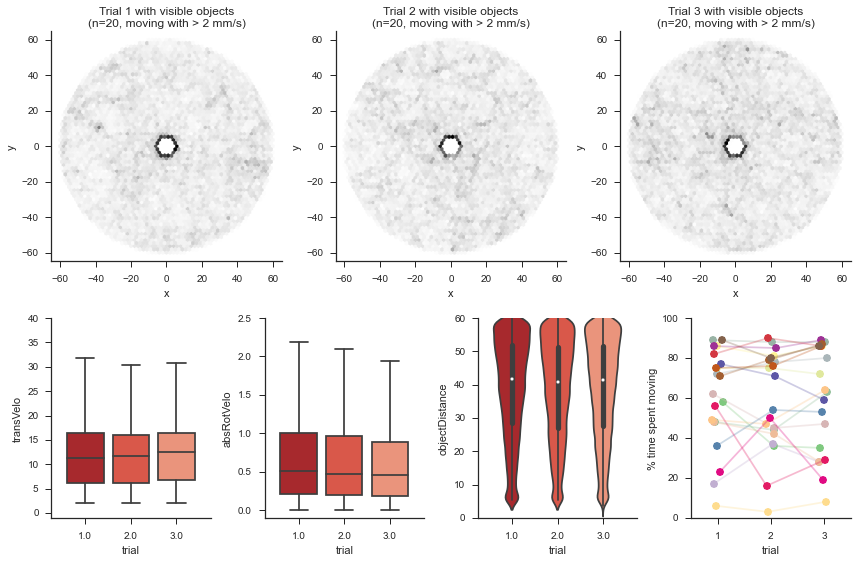

In [42]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

trialComparisonFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,12,height_ratios=[1,0.8])
numVItrials = 3
for trial in range(1,numVItrials+1):
    querystring = '(trial == ' + str(trial) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')

    # make plot
    sbplt = trialComparisonFig.add_subplot(gs[0,(trial-1)*4:trial*4]) #(1,numVItrials,trial)
    
    noNans = ~np.isnan(xPosMAall)
    titlestring = 'Trial '+str(trial)+' with visible objects\n(n='+str(nTrialsVI/numVItrials)+', moving with > '+str(vTransTH)+' mm/s)'

    hexplotfig_trial = plotResidencyInMiniarena(sbplt, xPosMAall[noNans][movingall[noNans]],
                                                yPosMAall[noNans][movingall[noNans]],numBins, arenaRad,
                                                'Greys',titlestring)

FOAllFliesVisible_df = FOAllFlies_df.query('(trialtype == "visible") & (trial < 4) & (moving > 0)')
FOAllFliesVisible_df = FOAllFliesVisible_df[keylistLong]

FOAllFliesVisible_df.insert(keylistLong.index('rotVelo'), 'absRotVelo', abs(FOAllFliesVisible_df['rotVelo']))

#perTrialBP = plt.figure(figsize=(13,4))
perTrialBPvT = trialComparisonFig.add_subplot(gs[1,0:3])
sns.boxplot(x='trial', y='transVelo', 
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvT.set_ylim(-1,40)
perTrialBPvT.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvT)

perTrialBPvR = trialComparisonFig.add_subplot(gs[1,3:6])
sns.boxplot(x='trial', y='absRotVelo',
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvR.set_ylim(-0.1,2.5)
perTrialBPvR.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvR)

perTrialVPod = trialComparisonFig.add_subplot(gs[1,6:9])
sns.violinplot(x='trial', y='objectDistance',data=FOAllFliesVisible_df,
               palette='Reds_r',sym='', bw=.1)
perTrialVPod.set_ylim(0,arenaRad)
perTrialVPod.set_xlim(-0.75,2.75)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,3))
randJitter = np.zeros((numFlies,3))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,9:12])

for fly in range(numFlies):
    for trial in range(3):
        querystring = '(trialtype == "visible") & (trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
        #perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int')        
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int')
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        randJitter[fly,trial] = jitter
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,4)+randJitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)

perFlyMovingPlt.set_xlabel('trial')
plt.xticks([1,2,3],[1,2,3], rotation='horizontal')
perFlyMovingPlt.set_ylabel('% time spent moving')
perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,3.5)
myAxisTheme(perFlyMovingPlt)

trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareVisibleTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir + 'compareVisibleTrials/'  + genotypeSex
                   + '_visibleTrials'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

In [43]:
trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareAllTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir+'compareAllTrials/'+genotype+'_'+flyIDs[0][0]
                   +'_allTrials'+'_n'+str(len(flyIDs))+'.pdf', format='pdf')

Analysis directory already exists.


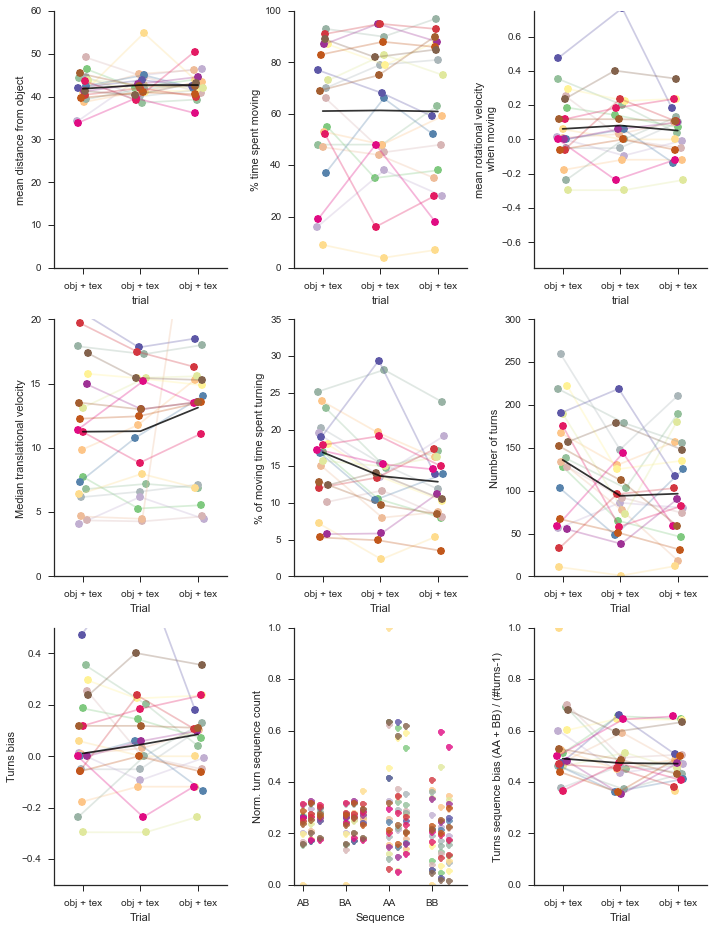

In [44]:
# make fly summary plot of residency:
arenaRad = 60
numtrials = len(visibilityState)-sum(['invisible' in visibilityState[trial] for trial in range(len(visibilityState))])

minTurnDist = 5

minDist = 10
maxDist = 60

trialComparisonFig = plt.figure(figsize=(10,13))
gs = gridspec.GridSpec(3,3) #,width_ratios=[1,0.9])

nTrial = [nTrialsVI/3, nTrialsVI/3,nTrialsVI/3]

# Top row plots: ...............................................................................................

# Plots of (a) percent of time spent moving, (b) rotational bias and (c) mean distance from object
percentMoving = np.zeros((numFlies,numtrials))
rotationBias = np.zeros((numFlies,numtrials))
meanObjDist = np.zeros((numFlies,numtrials))
jitter = np.zeros((numFlies,numtrials))

perFlyMeanDistPlt = trialComparisonFig.add_subplot(gs[0,0])
plt.xticks([1,2,3],trialName, rotation='horizontal')

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[0,1])
plt.xticks([1,2,3],trialName, rotation='horizontal')

perFlyRotBiasPlt = trialComparisonFig.add_subplot(gs[0,2])
plt.xticks([1,2,3],trialName, rotation='horizontal')


for fly in range(numFlies):
    for trial in range(numtrials):

        tJitter = np.random.uniform(-0.1, 0.1)
        jitter[fly,trial] = tJitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +'")'\
                        +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                       +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')
        perFlyObjDist = FOAllFlies_df.query(querystring).iloc[:,keyind_objD:keyind_objD+1].squeeze().astype('float')
        
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,trial] = np.nanmedian(perFlyRot)
        meanObjDist[fly,trial] = np.nanmedian(perFlyObjDist)
        
        perFlyMovingPlt.plot(trial+1+tJitter,percentMoving[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))

        perFlyRotBiasPlt.plot(trial+1+tJitter,rotationBias[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        perFlyMeanDistPlt.plot(trial+1+tJitter,meanObjDist[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+jitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    perFlyRotBiasPlt.plot(range(1,numtrials+1)+jitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
        
    perFlyMeanDistPlt.plot(range(1,numtrials+1)+jitter[fly,:],meanObjDist[fly,:],'-',
                         markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,numtrials+1),np.nanmean(rotationBias,axis=0),color='k',alpha=0.8)
perFlyMeanDistPlt.plot(range(1,numtrials+1),np.nanmean(meanObjDist,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMeanDistPlt.set_ylim(0,arenaRad)
perFlyMeanDistPlt.set_xlim(0.5,numtrials+0.5)
perFlyMeanDistPlt.set_xlabel('trial')
perFlyMeanDistPlt.set_ylabel('mean distance from object')
myAxisTheme(perFlyMeanDistPlt)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('trial')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.75,0.75)
perFlyRotBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyRotBiasPlt.set_xlabel('trial')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity \n when moving')
myAxisTheme(perFlyRotBiasPlt)

# Bottom row plots: ...............................................................................................

# Only include moving flies
querystring = '(moving > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 2*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -2*np.std(vRot_filt[vRot_filt<=0])

percentMoving = np.zeros((numFlies,numtrials))
perFlyTurnTH = np.zeros((numFlies,numtrials))
perFlyNumTurn = np.zeros((numFlies,numtrials))
perFlyTurnDir = np.zeros((numFlies,numtrials))
perFlyTurnSeqBias = np.zeros((numFlies,numtrials))

randJitter = np.zeros((numFlies,numtrials))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,0])
plt.xticks([1,2,3],trialName, rotation='horizontal')
perFlyTurnTHPlt = trialComparisonFig.add_subplot(gs[1,1])
plt.xticks([1,2,3],trialName, rotation='horizontal')
perFlyNumTurnPlt = trialComparisonFig.add_subplot(gs[1,2])
plt.xticks([1,2,3],trialName, rotation='horizontal')

perFlyTurnDirPlt = trialComparisonFig.add_subplot(gs[2,0])
plt.xticks([1,2,3],trialName, rotation='horizontal')
perFlyTurnSeqPlt = trialComparisonFig.add_subplot(gs[2,1])
plt.xticks([0,1,2,3],['AB','BA','AA','BB'])
perFlyTurnSeqBiasPlt = trialComparisonFig.add_subplot(gs[2,2])
plt.xticks([1,2,3],trialName, rotation='horizontal')

for fly in range(numFlies):
    for trial in range(numtrials):
        
        jitter = np.random.uniform(-0.1, 0.1)
        randJitter[fly,trial] = jitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'\
                      +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        if perFlyMoving.size < 5:
            continue
            
        if 100.0*sum(perFlyMoving)/max(1,len(perFlyMoving)) < 0:
            percentMoving[fly,trial] = np.nan
            perFlyTurnTH[fly,trial] = np.nan
            perFlyNumTurn[fly,trial] = np.nan
            perFlyTurnDir[fly,trial] = np.nan
            perFlyTurnSeqBias[fly,trial] = np.nan
            continue

        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                      +'& (objectDistance >='+str(minDist)+') & (objectDistance <='+str(maxDist)+')'
        perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
        
        perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')
        
        turnMask = np.logical_or(perFlyRot_filt>turnTH_pos,perFlyRot_filt<turnTH_neg)
        turnLoc = np.where(turnMask>0)[0]
        turnStart = turnLoc[np.where(np.hstack((0,np.diff(turnLoc)))>minTurnDist)[0]]
        turnSide = np.sign(perFlyRot[turnStart])
        
        try:
            turnSeq = np.zeros(len(turnStart)-1)
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==0.5)[0]] = 2
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-0.5)[0]] = 3
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-1.5)[0]] = 0
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-2.5)[0]] = 1
            
            numBin = 4
            [n,edgs] = np.histogram(turnSeq,bins=numBin)
        
        except ValueError:
            print('Not enought turns in fly' + str(fly))
            n = np.ones(numBin)*np.nan
            
        perFlyTurnTH[fly,trial] = 100.0*(sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg))/max(1,len(perFlyRot_filt))
        perFlyNumTurn[fly,trial] = len(turnStart)
        perFlyTurnDir[fly,trial] = np.nanmedian(perFlyRot)
        #abs((1.0*sum(perFlyRot_filt>turnTH_pos) - sum(perFlyRot_filt<turnTH_neg))/
        #                               max(1.0*sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg),1))
        if sum(n)==0:
            perFlyTurnSeqBias[fly,trial] = np.nan
        else:
            perFlyTurnSeqBias[fly,trial] = float(sum(n[2:]))/sum(n)
        
        alphaVal = min(perFlyNumTurn[fly,trial]/3,1)
        
        percentMoving[fly,trial] = np.nanmedian(perFlyTra)
        
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnTHPlt.plot(trial+1+jitter,perFlyTurnTH[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyNumTurnPlt.plot(trial+1+jitter,perFlyNumTurn[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyTurnDirPlt.plot(trial+1+jitter,perFlyTurnDir[fly,trial],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqPlt.plot(range(numBin)+np.ones(numBin)*0.2*trial,n/(np.ones(numBin)*sum(n)),
                              marker = 'o',linestyle='none',alpha = 0.8,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqBiasPlt.plot(trial+1+jitter,perFlyTurnSeqBias[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+randJitter[fly,:],percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)    
    perFlyTurnTHPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnTH[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyNumTurnPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyNumTurn[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnDirPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnDir[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnSeqBias[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyTurnTHPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnTH,axis=0),color='k',alpha=0.8)
perFlyNumTurnPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyNumTurn,axis=0),color='k',alpha=0.8)
perFlyTurnDirPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnDir,axis=0),color='k',alpha=0.8)
perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnSeqBias,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMovingPlt.set_ylim(0,20)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('Trial')
perFlyMovingPlt.set_ylabel('Median translational velocity')
myAxisTheme(perFlyMovingPlt)

perFlyTurnTHPlt.set_ylim(0,35)
perFlyTurnTHPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnTHPlt.set_xlabel('Trial')
perFlyTurnTHPlt.set_ylabel('% of moving time spent turning')
myAxisTheme(perFlyTurnTHPlt)

perFlyNumTurnPlt.set_xlim(0.5,numtrials+0.5)
perFlyNumTurnPlt.set_xlabel('Trial')
perFlyNumTurnPlt.set_ylabel('Number of turns')
myAxisTheme(perFlyNumTurnPlt)

perFlyTurnDirPlt.set_ylim(-0.5,0.5)
perFlyTurnDirPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnDirPlt.set_xlabel('Trial')
perFlyTurnDirPlt.set_ylabel('Turns bias')
myAxisTheme(perFlyTurnDirPlt)

perFlyTurnSeqPlt.set_ylim(0,1)
perFlyTurnSeqPlt.set_xlim(-0.2,numBin-0.2)
perFlyTurnSeqPlt.set_xlabel('Sequence')
perFlyTurnSeqPlt.set_ylabel('Norm. turn sequence count')
myAxisTheme(perFlyTurnSeqPlt)

perFlyTurnSeqBiasPlt.set_ylim(0,1)
perFlyTurnSeqBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnSeqBiasPlt.set_xlabel('Trial')
perFlyTurnSeqBiasPlt.set_ylabel('Turns sequence bias (AA + BB) / (#turns-1)')
myAxisTheme(perFlyTurnSeqBiasPlt)

trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareAllTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir+'compareVisibleTrials/'+genotype+'_'+flyIDs[0][0]
                   +'_visibleTrials_allFlies'+'_n'+str(len(flyIDs))+'.pdf', format='pdf')

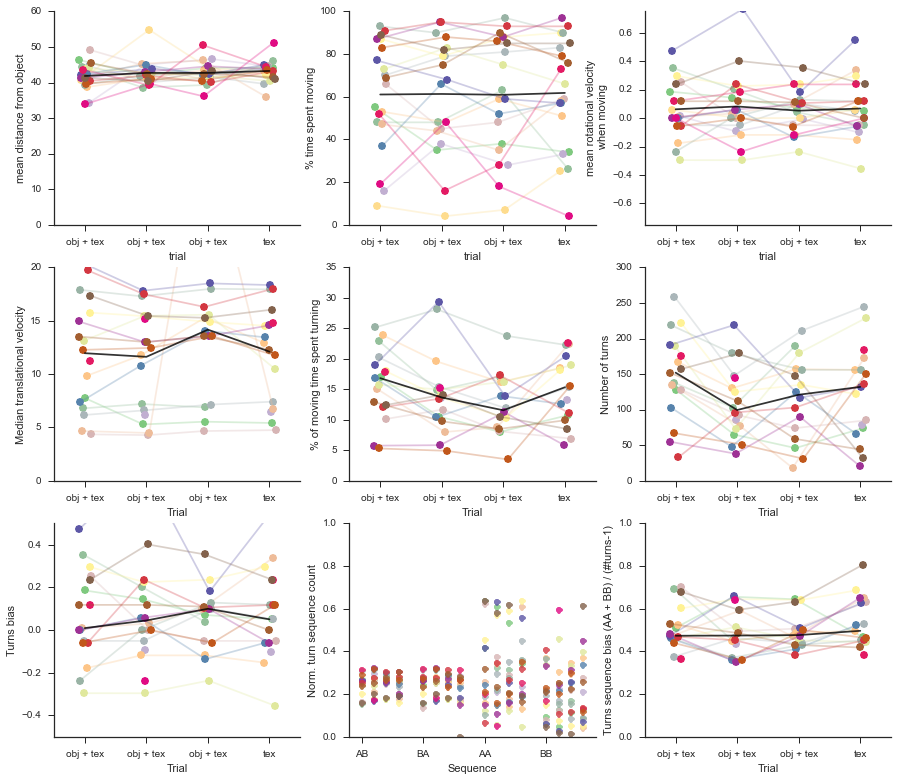

In [45]:
# make fly summary plot of residency:
arenaRad = 60
numtrials = len(visibilityState)
numINtrials = sum(['invisible' in visibilityState[trial] for trial in range(len(visibilityState))])
numVItrials = len(visibilityState)-numINtrials

minTurnDist = 5

minDist = 10
maxDist = 60

trialComparisonFig = plt.figure(figsize=(15,13))
gs = gridspec.GridSpec(3,3) #,width_ratios=[1,0.9])

nTrial = [nTrialsVI/3, nTrialsVI/3,nTrialsVI/3, nTrialsIN]

# Top row plots: ...............................................................................................

# Plots of (a) percent of time spent moving, (b) rotational bias and (c) mean distance from object
percentMoving = np.zeros((numFlies,numtrials))
rotationBias = np.zeros((numFlies,numtrials))
meanObjDist = np.zeros((numFlies,numtrials))
jitter = np.zeros((numFlies,numtrials))

perFlyMeanDistPlt = trialComparisonFig.add_subplot(gs[0,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[0,1])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyRotBiasPlt = trialComparisonFig.add_subplot(gs[0,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')


for fly in range(numFlies):
    for trial in range(numtrials):

        tJitter = np.random.uniform(-0.1, 0.1)
        jitter[fly,trial] = tJitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +'")'\
                        +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                       +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')
        perFlyObjDist = FOAllFlies_df.query(querystring).iloc[:,keyind_objD:keyind_objD+1].squeeze().astype('float')
        
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,trial] = np.nanmedian(perFlyRot)
        meanObjDist[fly,trial] = np.nanmedian(perFlyObjDist)
        
        perFlyMovingPlt.plot(trial+1+tJitter,percentMoving[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))

        perFlyRotBiasPlt.plot(trial+1+tJitter,rotationBias[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        perFlyMeanDistPlt.plot(trial+1+tJitter,meanObjDist[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+jitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    perFlyRotBiasPlt.plot(range(1,numtrials+1)+jitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
        
    perFlyMeanDistPlt.plot(range(1,numtrials+1)+jitter[fly,:],meanObjDist[fly,:],'-',
                         markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,numtrials+1),np.nanmean(rotationBias,axis=0),color='k',alpha=0.8)
perFlyMeanDistPlt.plot(range(1,numtrials+1),np.nanmean(meanObjDist,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMeanDistPlt.set_ylim(0,arenaRad)
perFlyMeanDistPlt.set_xlim(0.5,numtrials+0.5)
perFlyMeanDistPlt.set_xlabel('trial')
perFlyMeanDistPlt.set_ylabel('mean distance from object')
myAxisTheme(perFlyMeanDistPlt)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('trial')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.75,0.75)
perFlyRotBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyRotBiasPlt.set_xlabel('trial')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity \n when moving')
myAxisTheme(perFlyRotBiasPlt)

# Bottom row plots: ...............................................................................................

# Only include moving flies
querystring = '(moving > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 2*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -2*np.std(vRot_filt[vRot_filt<=0])

percentMoving = np.zeros((numFlies,numtrials))
perFlyTurnTH = np.zeros((numFlies,numtrials))
perFlyNumTurn = np.zeros((numFlies,numtrials))
perFlyTurnDir = np.zeros((numFlies,numtrials))
perFlyTurnSeqBias = np.zeros((numFlies,numtrials))

randJitter = np.zeros((numFlies,numtrials))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyTurnTHPlt = trialComparisonFig.add_subplot(gs[1,1])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyNumTurnPlt = trialComparisonFig.add_subplot(gs[1,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyTurnDirPlt = trialComparisonFig.add_subplot(gs[2,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyTurnSeqPlt = trialComparisonFig.add_subplot(gs[2,1])
plt.xticks([0,1,2,3],['AB','BA','AA','BB'])
perFlyTurnSeqBiasPlt = trialComparisonFig.add_subplot(gs[2,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

for fly in range(numFlies):
    for trial in range(numtrials):
        
        jitter = np.random.uniform(-0.1, 0.1)
        randJitter[fly,trial] = jitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'\
                      +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        if perFlyMoving.size < 5:
            continue
            
        if (100.0*sum(perFlyMoving))/max(1,len(perFlyMoving)) < 30:
            percentMoving[fly,trial] = np.nan
            perFlyTurnTH[fly,trial] = np.nan
            perFlyNumTurn[fly,trial] = np.nan
            perFlyTurnDir[fly,trial] = np.nan
            perFlyTurnSeqBias[fly,trial] = np.nan
            continue

        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                      +'& (objectDistance >='+str(minDist)+') & (objectDistance <='+str(maxDist)+')'
        perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
        
        perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')
        
        turnMask = np.logical_or(perFlyRot_filt>turnTH_pos,perFlyRot_filt<turnTH_neg)
        turnLoc = np.where(turnMask>0)[0]
        turnStart = turnLoc[np.where(np.hstack((0,np.diff(turnLoc)))>minTurnDist)[0]]
        turnSide = np.sign(perFlyRot[turnStart])
        
        try:
            turnSeq = np.zeros(len(turnStart)-1)
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==0.5)[0]] = 2
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-0.5)[0]] = 3
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-1.5)[0]] = 0
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-2.5)[0]] = 1
            
            numBin = 4
            [n,edgs] = np.histogram(turnSeq,bins=numBin)
        
        except ValueError:
            print('Not enought turns in fly' + str(fly))
            n = np.ones(numBin)*np.nan
            
        perFlyTurnTH[fly,trial] = 100.0*(sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg))/max(1,len(perFlyRot_filt))
        perFlyNumTurn[fly,trial] = len(turnStart)
        perFlyTurnDir[fly,trial] = np.nanmedian(perFlyRot)
        #abs((1.0*sum(perFlyRot_filt>turnTH_pos) - sum(perFlyRot_filt<turnTH_neg))/
        #                               max(1.0*sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg),1))
        if sum(n)==0:
            perFlyTurnSeqBias[fly,trial] = np.nan
        else:
            perFlyTurnSeqBias[fly,trial] = float(sum(n[2:]))/sum(n)
        
        alphaVal = min(perFlyNumTurn[fly,trial]/3,1)
        
        percentMoving[fly,trial] = np.nanmedian(perFlyTra)
        
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnTHPlt.plot(trial+1+jitter,perFlyTurnTH[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyNumTurnPlt.plot(trial+1+jitter,perFlyNumTurn[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyTurnDirPlt.plot(trial+1+jitter,perFlyTurnDir[fly,trial],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqPlt.plot(range(numBin)+np.ones(numBin)*0.2*trial,n/(np.ones(numBin)*sum(n)),
                              marker = 'o',linestyle='none',alpha = 0.8,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqBiasPlt.plot(trial+1+jitter,perFlyTurnSeqBias[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+randJitter[fly,:],percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)    
    perFlyTurnTHPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnTH[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyNumTurnPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyNumTurn[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnDirPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnDir[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnSeqBias[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyTurnTHPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnTH,axis=0),color='k',alpha=0.8)
perFlyNumTurnPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyNumTurn,axis=0),color='k',alpha=0.8)
perFlyTurnDirPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnDir,axis=0),color='k',alpha=0.8)
perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnSeqBias,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMovingPlt.set_ylim(0,20)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('Trial')
perFlyMovingPlt.set_ylabel('Median translational velocity')
myAxisTheme(perFlyMovingPlt)

perFlyTurnTHPlt.set_ylim(0,35)
perFlyTurnTHPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnTHPlt.set_xlabel('Trial')
perFlyTurnTHPlt.set_ylabel('% of moving time spent turning')
myAxisTheme(perFlyTurnTHPlt)

perFlyNumTurnPlt.set_xlim(0.5,numtrials+0.5)
perFlyNumTurnPlt.set_xlabel('Trial')
perFlyNumTurnPlt.set_ylabel('Number of turns')
myAxisTheme(perFlyNumTurnPlt)

perFlyTurnDirPlt.set_ylim(-0.5,0.5)
perFlyTurnDirPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnDirPlt.set_xlabel('Trial')
perFlyTurnDirPlt.set_ylabel('Turns bias')
myAxisTheme(perFlyTurnDirPlt)

perFlyTurnSeqPlt.set_ylim(0,1)
perFlyTurnSeqPlt.set_xlim(-0.2,numBin-0.2)
perFlyTurnSeqPlt.set_xlabel('Sequence')
perFlyTurnSeqPlt.set_ylabel('Norm. turn sequence count')
myAxisTheme(perFlyTurnSeqPlt)

perFlyTurnSeqBiasPlt.set_ylim(0,1)
perFlyTurnSeqBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnSeqBiasPlt.set_xlabel('Trial')
perFlyTurnSeqBiasPlt.set_ylabel('Turns sequence bias (AA + BB) / (#turns-1)')
myAxisTheme(perFlyTurnSeqBiasPlt)

## TODO: Generate data frame containing per fly averages for
### * percent time spent moving
### * average transl. velocity while moving
### * rotational velocity while moving
### * number of turns
### * number of visits
### * fraction of time spent within 20 mm radius around object

## Then check if flies cluster in space formed by combinations, i.e. if different behavioural measures are correlated

### Analysis of visits to the object

#### TODO: extract visits & plot trajectories prior to that

In [1]:
condition = "visible"
trial = 2
querystring = '(trialtype=="'+condition+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>6)'# & ((flyID== "WTBm10"))'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
walkingFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_walk:keyind_walk+1]).squeeze()

objDist = np.hypot(xPosFly,yPosFly)
theta = np.arctan2(yPosFly,xPosFly)

d_objDist = np.hstack((0, np.diff(np.convolve(objDist, np.ones((7,))/7, mode='same'))))
d_objDist[d_objDist>2] = 2
d_objDist[d_objDist<-2] = -2

d_gamma = np.hstack((0, np.diff(np.convolve(gammaFly, np.ones((7,))/7, mode='same'))))

NameError: name 'np' is not defined

(0, 100)

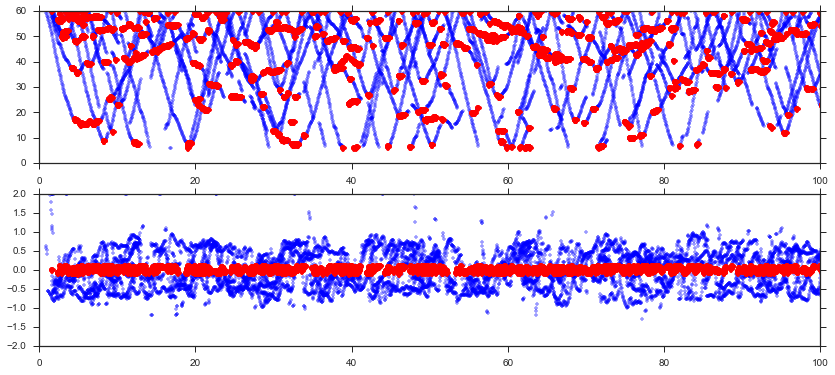

In [427]:
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(timeFly, objDist,'b.',alpha=0.4)
plt.plot(timeFly[abs(d_objDist)<0.1], objDist[abs(d_objDist)<0.1],'ro')
plt.plot(timeFly[objDist<6], objDist[objDist<6],'co')
plt.xlim(0,100)

plt.subplot(212)
plt.plot(timeFly, d_objDist,'b.',alpha=0.4)
plt.plot(timeFly[abs(d_objDist)<0.1], d_objDist[abs(d_objDist)<0.1],'ro')
plt.plot(timeFly[objDist<6], d_objDist[objDist<6],'co')
plt.xlim(0,100)

In [428]:
# extract indices of approach start and end

In [436]:
apr_pts = np.logical_and(filtddist<0, walkingFly>0)
apr_pts = np.logical_and(filtddist>0, walkingFly>0)

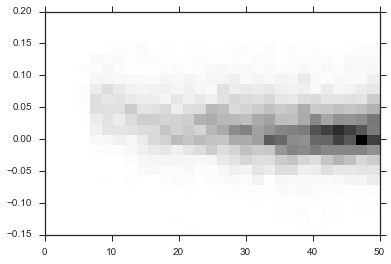

In [437]:
plt.figure(figsize = (12,5))
distEdges = np.linspace(0,50,30)
angleEdges = np.linspace(-0.15,0.15,20)

plt.subplot(121)
n, xedges, yedges = np.histogram2d(objDist[apr_pts], d_gamma[apr_pts], bins=(distEdges, angleEdges))
X, Y = np.meshgrid(yedges, xedges)
plt.pcolormesh(Y, X, n,cmap='Greys')
plt.subplot(122)
n, xedges, yedges = np.histogram2d(objDist[dep_pts], d_gamma[dep_pts], bins=(distEdges, angleEdges))
X, Y = np.meshgrid(yedges, xedges)
plt.pcolormesh(Y, X, n,cmap='Greys')

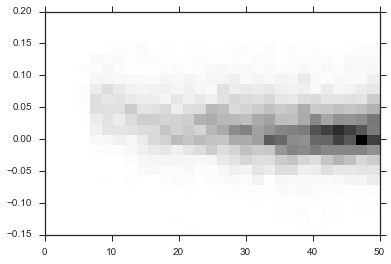

In [420]:
# TODO generate "test data", e.g. equidistant parallel lines crossing the miniarena

In [421]:
# TODO compare output of old procedural code below to output of function-based code

### Convert trajectory to polar coordinates and visualise trace and effect of turns

#### TODO: tidy up code

In [473]:
# Calculate turn threshold
# Only include moving flies
querystring = '(walking > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 3*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -3*np.std(vRot_filt[vRot_filt<=0])
turnTH = 3*np.std(abs(vRot_filt))

Analysis directory already exists.


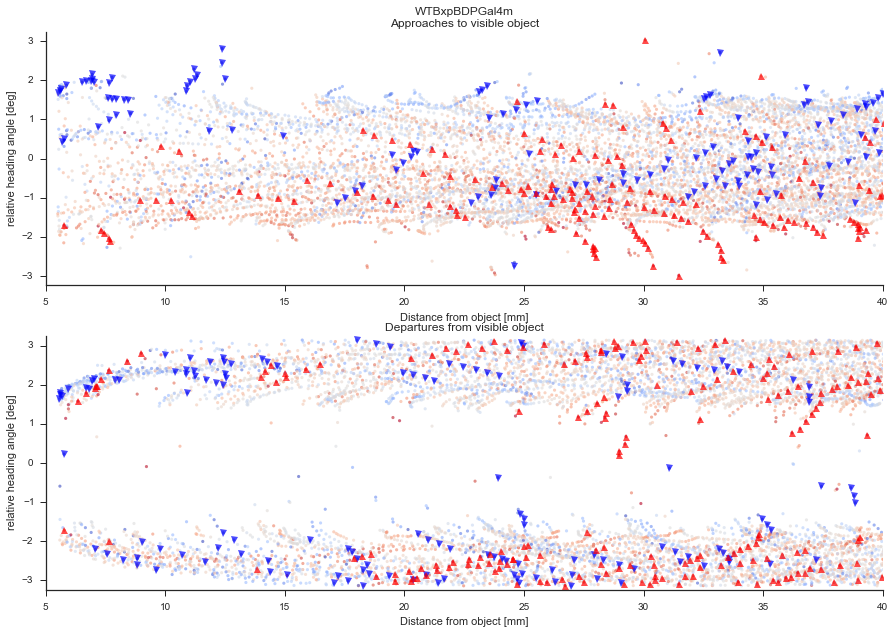

In [474]:
objecttype = "visible"
trial = 1
querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>5.5)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)

correctedPolarCurv = abs(polarCurv)*turnSign

# Plot
vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

titleString = genotypeSex

selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turn = np.logical_and(selectPts_apr,abs(vRotFly_filt) > turnTH)
selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFly_filt < turnTH_neg)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFly_filt > turnTH_pos)

selectPts_dep_turn = np.logical_and(selectPts_dep,abs(vRotFly_filt) > turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFly_filt < turnTH_neg)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFly_filt > turnTH_pos)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,40)

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,titleString + '\nApproaches to ' + objecttype + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ objecttype + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

try:
    mkdir(analysisDir + sep + 'polarTrace' + sep)
except OSError:
    print('Analysis directory already exists.')

fig.savefig(analysisDir + 'polarTrace/'+genotypeSex+'_'+objecttype+'Objects'+'_n'+ str(len(flyIDs))
            +'_polarTrace_trial' + str(trial) + '.pdf', format='pdf')


Analysis directory already exists.


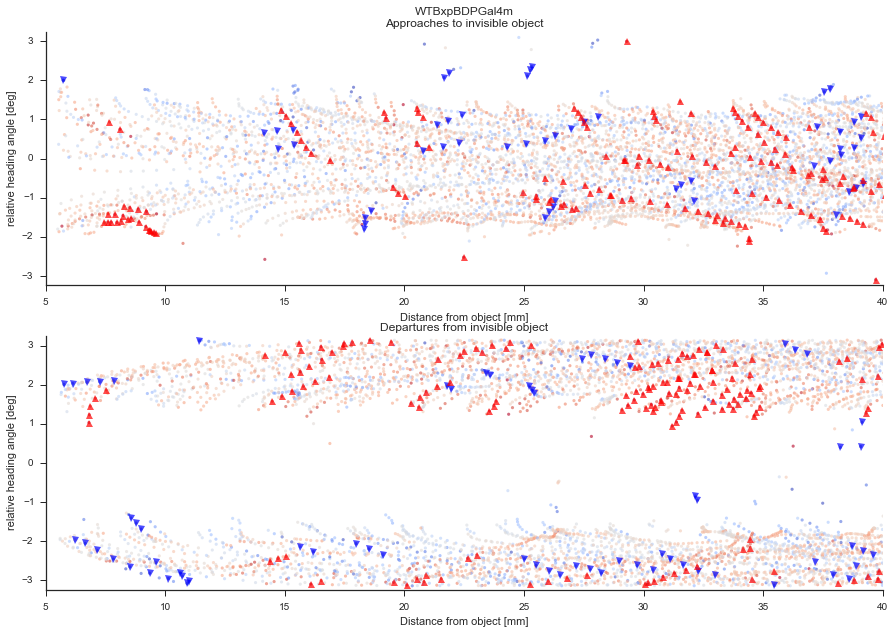

In [424]:
objecttype = "invisible"
trial = 4
querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>5.5)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)

correctedPolarCurv = abs(polarCurv)*turnSign

# Plot
vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

titleString = genotypeSex

selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turn = np.logical_and(selectPts_apr,abs(vRotFly_filt) > turnTH)
selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFly_filt < turnTH_neg)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFly_filt > turnTH_pos)

selectPts_dep_turn = np.logical_and(selectPts_dep,abs(vRotFly_filt) > turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFly_filt < turnTH_neg)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFly_filt > turnTH_pos)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,40)

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,titleString + '\nApproaches to ' + objecttype + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ objecttype + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

try:
    mkdir(analysisDir + sep + 'polarTrace' + sep)
except OSError:
    print('Analysis directory already exists.')

fig.savefig(analysisDir + 'polarTrace/'+genotypeSex+'_'+objecttype+'Objects'+'_n'+ str(len(flyIDs))
            +'_polarTrace_trial' + str(trial) + '.pdf', format='pdf')